In [ ]:
#Core Libraries
import numpy as np
import pandas as pd
import datetime as dt

#Visualization Libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

#Financial Data
import yfinance as yf

#Statistical and Mathematical Tools
from scipy import stats
from scipy.stats import norm, kurtosis, skew
from scipy.optimize import minimize

#Statsmodels for Statistical Tests and Models
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

#Machine Learning Tools
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import itertools

from datetime import datetime, timedelta



<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;"> Introduction


</div>


This project aims to analyze the behavior and risk characteristics of a selected portfolio comprising 12 prominent U.S. publicly traded companies, including technology giants like Apple, Microsoft, and Tesla, as well as firms from energy, finance, and retail sectors. The analysis integrates a range of mathematical and statistical tools to study stock performance, portfolio risk, and market dynamics.

The project begins with historical data collection, followed by a Monte Carlo simulation to project future price paths and estimate Value at Risk (VaR) and Conditional Value at Risk (CVaR). Various distributions are examined to understand the behavior of stock returns and trading volumes. An Efficient Frontier is constructed to explore optimal portfolio allocation.

Correlation analysis helps reveal relationships between stocks based on returns and volumes. Further, statistical significance is assessed through p-values. The project also investigates the behavior of price changes using first and second derivatives, computing their sums, averages, and standard deviations.

Principal Component Analysis (PCA) is applied to identify key patterns in stock returns and understand the contribution of each asset to overall variance. The goal is to provide insights into portfolio risk, asset interdependence, and dimensionality reduction in financial data using mathematical techniques.

Finaly is executed Black–Scholes model to analysis Call and Put Options 

---

## **List of Stocks Observed**
1. **AAPL** - Apple Inc.  
2. **MSFT** - Microsoft Corporation  
3. **TSLA** - Tesla, Inc.  
4. **GOOG** - Alphabet Inc. (Google)  
5. **NVDA** - NVIDIA Corporation  
6. **META** - Meta Platforms, Inc. (formerly Facebook, Inc.)  
7. **SNPS** - Synopsys, Inc.  
8. **CDNS** - Cadence Design Systems, Inc.  
9. **XOM** - Exxon Mobil Corporation  
10. **JPM** - JPMorgan Chase & Co.  
11. **WMT** - Walmart Inc.  
12. **AMC** - AMC Entertainment Holdings, Inc.  

---

## **Project Structure**

### 1. **Fetching Data and Calculate Close, Volume, Returns**
- 1.1 Parameters of the Project
- 1.2 Function for Fetching Data and Calculate Close, Volume, Returns

### 2. **Monte Carlo Simulation with VaR/CVaR**
- 2.1 Monte Carlo Simulation of 12 US Public Stocks for 200 days with 100 simulations per day + Efficient Frontier Simulation 
- 2.2 Calculate VaR and CVaR  
- 2.3 Plotting VaR, CVaR, Mean of Portfolio and Standard Deviation of Portfolio  

### 3. **Efficient Frontier**

### 4. **Combinations of Portfolios**

### 5. **Distribution of the Portfolio Scenarios**

### 6. **Skewness and Kurtosis of Portfolio**

### 7. **Distribution of Returns and Volumes**
- 7.1 Distribution of Return of Stocks for the Investigated Period
- 7.2 Distribution of Volumes of Stocks in the Observation 

### 8. **Correlation Heatmap of Volume and Returns**

### 9. **Probability Value (One-sided P-Value) based on T-test**

### 10. **First and second Derivatives of stocks**
- 10.1 First Derivative  
- 10.2 Sum, Average, Standard Deviation of First Derivative  
- 10.3 Second Derivative  
- 10.4 Sum, Average, Standard Deviation of Second Derivative  

### 11. **Principal Component Analysis**
- 11.1 PCA of Stock Returns: First Two Principal Components  
- 11.2 PCA Loading Plot: Contribution of Each Stock to PC1 and PC2  
- 11.3 Cumulative Explained Variance by Principal Components  

### 12. **Black–Scholes model**
- 12.1 Global variables to store data
- 12.2 Fetch real stock data from yfinance
- 12.3 Calculate historical volatility
- 12.4 Fetch Risk-free rate from Treasury data
- 12.5 Fetch real option chain data from yfinance
- 12.6 Calculate Black-Scholes option price (using Black-Scholes formula)
- 12.7 Calculate option Greeks
- 12.8 Calculate implied volatility using Newton-Raphson method
- 12.9 Compare Black-Scholes prices with real market data
- 12.10 Create comprehensive option analysis plots
- 12.11 Run complete enhanced Black-Scholes analysis
- 12.12 Execution of Black–Scholes for all stocks in list


<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">1. Fetching Data


<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">1.1 Parameters of the Project

In [ ]:
stocklist = ['AAPL', 'MSFT', 'TSLA', 'GOOG', 'NVDA', 'META', 'SNPS', 'CDNS', 'XOM', 'JPM', 'WMT', 'AMC'] #Stocks that will be observed, AMC is Meme Stock 
initialPortfolio = 50000 #Starting Invetment
days = 200 #Calendar Period of observation - 200 days
endDate = dt.datetime(2024, 6, 3) 
startDate = endDate - dt.timedelta(days=days)
num_assets = len(stocklist)
dayily_simulations = 100
portfolio_size = 5
colors = ['blue', 'green', 'grey', 'orange', 'purple', 'cyan', 'magenta', 'yellow']

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">1.2 Function for Fetching Data and Calculate Close, Volume, Returns

In [3]:
def get_stock_data(stocks, start_date, end_date):

    data = yf.download(stocks, start=start_date, end=end_date)
    
    adjustedClose = data['Close']
    volume = data['Volume']
    
    returns = adjustedClose.pct_change()
    
    meanReturns = returns.mean()
    covMatrix = returns.cov()
    
    returns = returns.dropna().reset_index()
    volume = volume.reset_index()
    adjustedClose = adjustedClose.reset_index()
    
    return meanReturns, covMatrix, returns, volume, adjustedClose

meanReturns, covMatrix, returns, volume, adjustedClose = get_stock_data(stocklist, startDate, endDate)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  12 of 12 completed


<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">2. Monte Carlo Simulation and VaR/CVaR


<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">2.1 Monte Carlo Simulation of 12 US Public Stocks for 200 days with 100 simulations per day + Efficient Frontier Simulation



In the graphic below you can see visualized Mone carlo Simulation based on period 16 Nov 2023 to 3 Jun 2024 - 200 days historical price of some of the most popular Wall Street stocks at the moment. 

The main idea of code is based on historical price for 200 days to make simulations for another 200 days where per day is generating 100 simulations. After makeing simulations we can take start analysys of key metrics which are showing on the graphic - Mean, Standard Deviation, Value at Risk (VaR), Continue Value At Risk (CVaR)

VaR is showing that the portfolio loss will not exceed VaR amout over the time of simulation. Which also mean that there is 5 % chane the loss to be greater than 6 001 USD.

CVaR is a tool in modern risk management, providing insights into potential extreme losses that are not captured by VaR. Its ability to account for the average of worst-case scenarios makes it a preferred risk measure for financial institutions looking to safeguard against significant market downturns and other tail risks. In our simulation we have CVaR of 9 437 USD.

Portfolio vary from 4 000 USD to 100 000 USD depending on the scenario. Standard Deviation cross Mean aprocimately on 30th day.

In [ ]:
# Create arrays for mean returns and portfolio simulations
meanM = np.full(shape=(days, len(stocklist)), fill_value=meanReturns).T
portfolio_sims = np.full(shape=(days, dayily_simulations), fill_value=0.0)

results_ef = np.zeros((3, dayily_simulations))  # Note: should be dayily_simulations, not days

#Monte Carlo simulation with matching weights for Efficient Frontier
for m in range(dayily_simulations):
    # Generate new random weights for this iteration
    weights = np.random.random(len(stocklist))
    weights /= np.sum(weights)
    
    # Simulate correlated daily returns
    Z = np.random.normal(size=(days, len(stocklist)))
    L = np.linalg.cholesky(covMatrix)
    dailyReturns = meanM + np.inner(L, Z)
    
    # Calculate portfolio cumulative returns using the same weights
    portfolio_sims[:, m] = np.cumprod(np.inner(weights, dailyReturns.T) + 1) * initialPortfolio

    # Calculate Efficient Frontier metrics with the same weights
    returns_mc = np.sum(weights * meanReturns)
    volatility = np.sqrt(np.dot(weights.T, np.dot(covMatrix, weights)))
    results_ef[0, m] = returns_mc
    results_ef[1, m] = volatility
    results_ef[2, m] = returns_mc / volatility

# Calculate statistics over all simulations
mean_portfolio = portfolio_sims.mean(axis=1)
std_portfolio = portfolio_sims.std(axis=1)

mean_last_day_value = mean_portfolio[-1]
std_last_day_value = std_portfolio[-1]

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">2.2 Calculate VaR and CVaR


In [5]:
def mcVaR(returns_mc, alpha=5):
    if isinstance(returns_mc, pd.Series):
        return np.percentile(returns_mc, alpha) #Calculates and returns the alpha percentile (5th percentile by default) of the returns_mc
    else:
        raise TypeError("Expected a pandas data series.")

def mcCVaR(returns_mc, alpha=5):
    if isinstance(returns_mc, pd.Series):
        belowVaR = returns_mc <= mcVaR(returns_mc, alpha=alpha)
        return returns_mc[belowVaR].mean() # Returns the average (mean) of all returns that fall below or at the VaR threshold
    else:
        raise TypeError("Expected a pandas data series.")

portResult = pd.Series(portfolio_sims[-1,:]) #2D to 1D conversion

VaR = initialPortfolio - mcVaR(portResult, alpha=5)
CVaR = initialPortfolio - mcCVaR(portResult, alpha=5)

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">2.3 Plotting VaR, CVaR, Mean of Portfolio and Standard Deviation of Portfolio


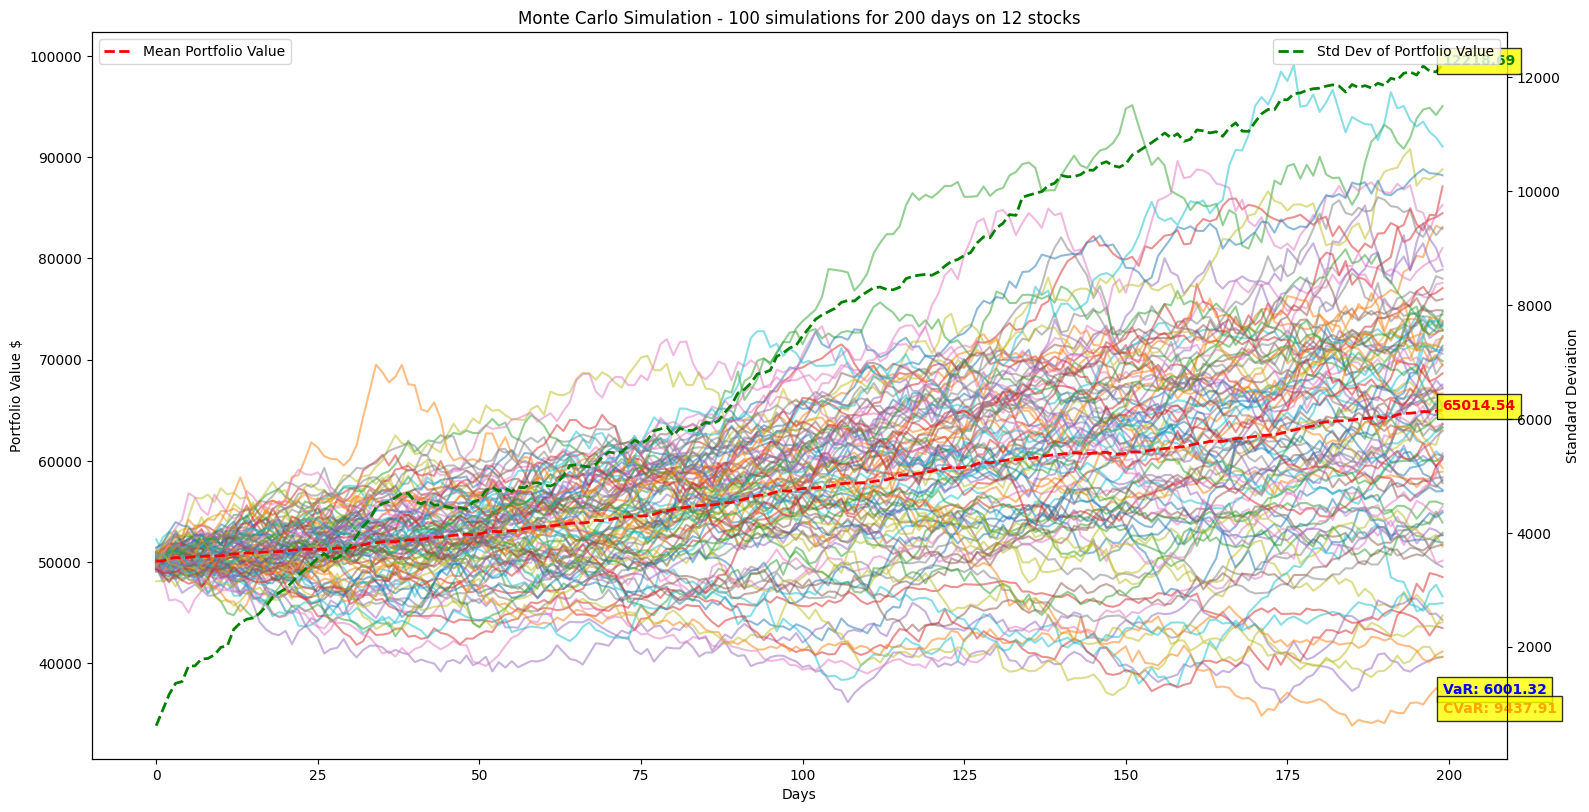

In [6]:
fig, ax1 = plt.subplots(figsize=(16, 8))

ax1.set_xlabel('Days')
ax1.set_ylabel('Portfolio Value $')
ax1.plot(portfolio_sims, alpha=0.5)
ax1.plot(mean_portfolio, color='red', linewidth=2, linestyle='dashed', label='Mean Portfolio Value')
ax1.tick_params(axis='y')

ax1.text(days-1, mean_last_day_value, f'{mean_last_day_value:.2f}', fontsize=10, color='red', fontweight='bold', bbox=dict(facecolor='yellow', alpha=0.8))

ax2 = ax1.twinx()
ax2.set_ylabel('Standard Deviation')
ax2.plot(std_portfolio, color='green', linewidth=2, linestyle='dashed', label='Std Dev of Portfolio Value')
ax2.tick_params(axis='y')

ax2.text(days-1, std_last_day_value, f'{std_last_day_value:.2f}', fontsize=10, color='green', fontweight='bold', bbox=dict(facecolor='yellow', alpha=0.8))

ax1.text(days-1, min(portfolio_sims[-1,:]), f'VaR: {VaR:.2f}', fontsize=10, color='blue', fontweight='bold', bbox=dict(facecolor='yellow', alpha=0.8))
ax1.text(days-1, min(portfolio_sims[-1,:]) * 0.95, f'CVaR: {CVaR:.2f}', fontsize=10, color='orange', fontweight='bold', bbox=dict(facecolor='yellow', alpha=0.8))

fig.tight_layout()
plt.title(f'Monte Carlo Simulation - {dayily_simulations} simulations for {days} days on {len(stocklist)} stocks')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">3. Efficient Frontier


The efficient frontier is a fundamental concept in modern portfolio theory (MPT) developed by Harry Markowitz. It represents a set of optimal portfolios that offer the highest expected return for a given level of risk (or conversely, the lowest risk for a given level of expected return).

<b>Key points that define the Efficient Frontier:</b>

Risk and Return Trade-off: The efficient frontier illustrates the optimal trade-off between expected return and risk, offering the highest return for a given level of risk or the lowest risk for a given return.

Diversification Benefit: Modern Portfolio Theory (MPT) emphasizes diversification to reduce risk. The efficient frontier demonstrates how various asset combinations can achieve different expected returns while minimizing overall portfolio risk.

Mathematical Formulation: The efficient frontier is derived using optimization techniques to maximize the Sharpe ratio, which measures excess return per unit of risk and evaluates investment performance relative to its risk.

Portfolio Construction: Investors use the efficient frontier to build portfolios that match their risk tolerance and return objectives, creating diversified portfolios that balance risk and return according to their preferences.

Dynamic Nature: The efficient frontier shifts due to changes in asset prices, correlations, and risk preferences, necessitating periodic portfolio adjustments to maintain alignment with investment goals and market conditions.

In general, a higher Sharpe Ratio is considered better because it indicates that an investment or portfolio has delivered higher returns relative to the amount of risk taken. 
In our simulation Max Shape ratio has value ... which is value for day number ...

![Shape Ratio](shape_ratio.jpg)


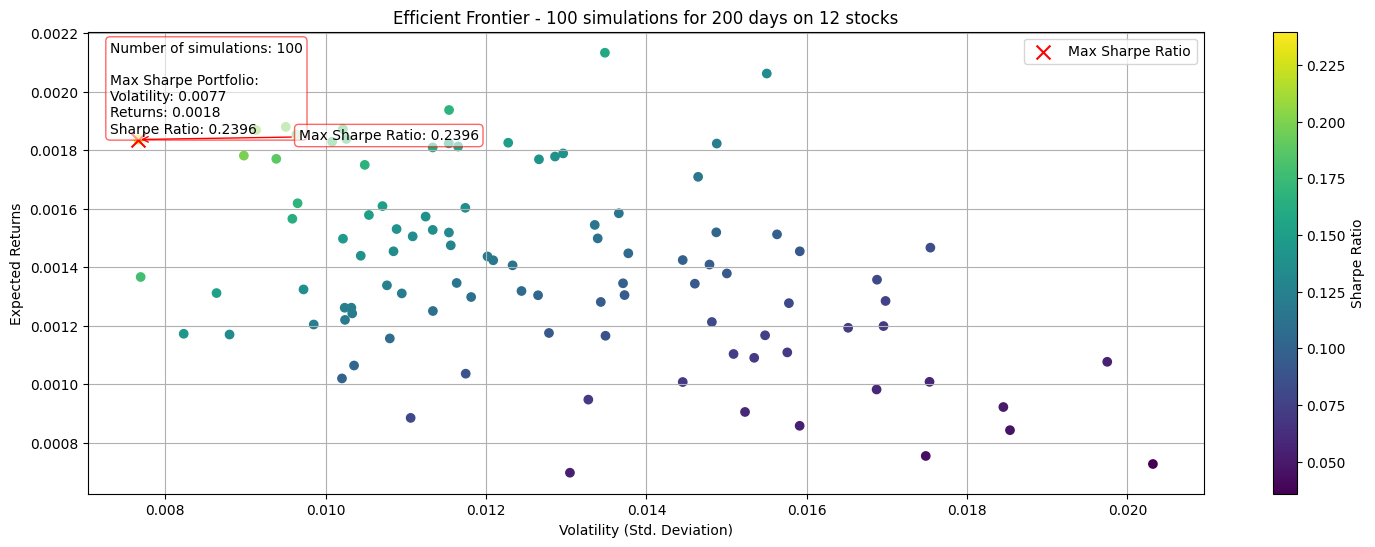

In [37]:
# Assume results_ef, dayily_simulations, days, stocklist are defined
results_df = pd.DataFrame(results_ef.T, columns=['Returns', 'Volatility', 'Sharpe Ratio'])

max_sharpe_portfolio = results_df.iloc[results_df['Sharpe Ratio'].idxmax()]# Find portfolio with maximum Sharpe Ratio

# Create the plot
plt.figure(figsize=(18, 6))
scatter = plt.scatter(results_df['Volatility'], results_df['Returns'], 
                      c=results_df['Sharpe Ratio'], cmap='viridis', marker='o')
plt.title(f'Efficient Frontier - {dayily_simulations} simulations for {days} days on {len(stocklist)} stocks')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.colorbar(label='Sharpe Ratio')
plt.grid(True)

num_points = len(results_df) # Number of simulations

# Plot 
plt.scatter(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Returns'], 
            marker='x', color='red', s=100, label='Max Sharpe Ratio')
plt.legend()

bbox_props = dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="white", alpha=0.6)
plt.text(0.02, 0.98, 
         f'Number of simulations: {num_points}\n\n'
         f"Max Sharpe Portfolio:\nVolatility: {max_sharpe_portfolio['Volatility']:.4f}\n"
         f"Returns: {max_sharpe_portfolio['Returns']:.4f}\n"
         f"Sharpe Ratio: {max_sharpe_portfolio['Sharpe Ratio']:.4f}",
         ha='left', va='top', transform=plt.gca().transAxes, bbox=bbox_props)

plt.annotate(f"Max Sharpe Ratio: {max_sharpe_portfolio['Sharpe Ratio']:.4f}",
             xy=(max_sharpe_portfolio['Volatility'], max_sharpe_portfolio['Returns']),
             xytext=(max_sharpe_portfolio['Volatility'] + 0.002, max_sharpe_portfolio['Returns']),
             arrowprops=dict(arrowstyle="->", color='red'),
             bbox=dict(boxstyle="round,pad=0.3", edgecolor="red", facecolor="white", alpha=0.6),
             fontsize=10,
             color='black')

plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">4. Combinations of Portfolios



This code analyzes all possible equal-weighted combinations of a specified number of stocks based on historical daily return data.  
For each portfolio, it calculates key metrics including **average daily return**, **volatility**, and **probability of loss**.  
A custom score is computed that favors high return and low risk, adjusting for the likelihood of negative returns.  
The **final portfolio value** is simulated using cumulative returns from an initial investment.  
The top 5 portfolios, ranked by score, are visualized in a **scatter plot** showing score vs. final value, with color representing average return.

The key difference between this method and Monte Carlo simulation is that Monte Carlo assigns random weights to all assets, whereas this approach evaluates combinations of stocks using equal weights.

![Shape Ratio](score_formula.jpg)
![Shape Ratio](probability_of_loss.jpg)


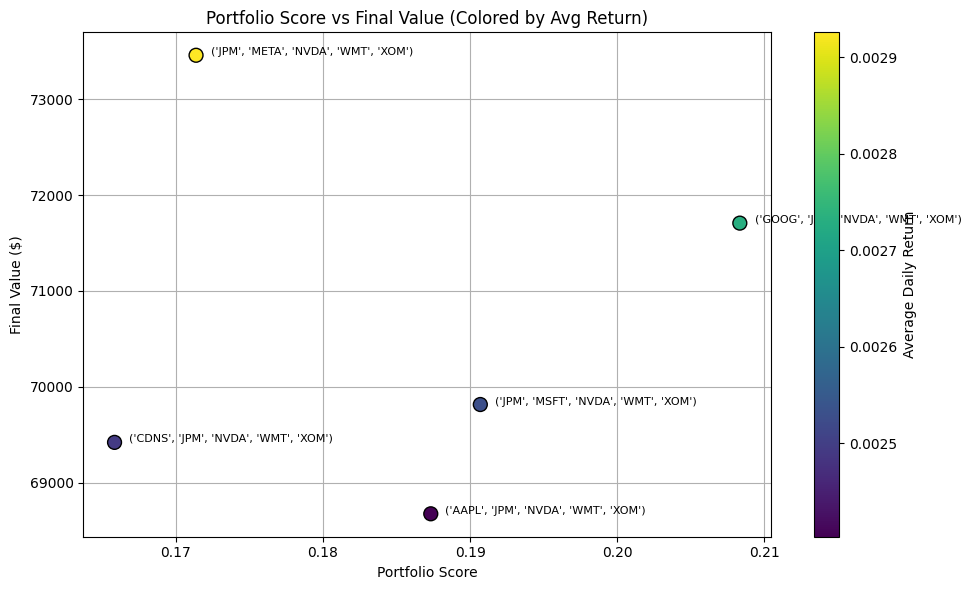

In [8]:
returns = returns.set_index('Date') 

results = []

stock_list = returns.columns.tolist()
combinations = list(itertools.combinations(stock_list, portfolio_size))

for combo in combinations:
    # Subset data for selected stocks
    portfolio_returns = returns[list(combo)].mean(axis=1)  # equal-weighted daily return
    
    avg_daily_return = portfolio_returns.mean()
    volatility = portfolio_returns.std()
    prob_loss = (portfolio_returns < 0).mean()
    
    # Simple scoring metric: Sharpe-like with penalty for loss probability
    score = (avg_daily_return / volatility) * (1 - prob_loss)
    
    # Simulate final portfolio value
    cumulative_return = (1 + portfolio_returns).prod()
    final_value = initialPortfolio * cumulative_return

    results.append({
        "Stocks": combo,
        "Avg Return": avg_daily_return,
        "Volatility": volatility,
        "Prob Loss": prob_loss,
        "Score": score,
        "Final Value": final_value
    })

results_df = pd.DataFrame(results)
top_portfolios = results_df.sort_values(by="Score", ascending=False)
top_portfolios = top_portfolios.head(5)
df_sorted = top_portfolios.sort_values(by="Score", ascending=False)

fig, ax = plt.subplots(figsize=(10,6))
scatter = ax.scatter(
    df_sorted['Score'],
    df_sorted['Final Value'],
    c=df_sorted['Avg Return'],
    cmap='viridis',
    s=100,
    edgecolors='black'
)

for i, txt in enumerate(df_sorted['Stocks']):
    ax.annotate(txt, (df_sorted['Score'].iloc[i] + 0.001, df_sorted['Final Value'].iloc[i]), fontsize=8)

ax.set_xlabel('Portfolio Score')
ax.set_ylabel('Final Value ($)')
ax.set_title('Portfolio Score vs Final Value (Colored by Avg Return)')
plt.colorbar(scatter, label='Average Daily Return')
plt.grid(True)
plt.tight_layout()
plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">5. Distribution of the Portfolio Scenarios


On the graphic we can see symmetric distribution which is also Platykurtic characterised by lower kurtosis than a normal distribution. Distribution has also flatter peak means the points of portfolio simulations are more evenly spread out around the mean, thin tails indicating less probability of extreme values in simulated portfolios.

Z-score of the distribution is below +/- 2 which describes it as normal risky


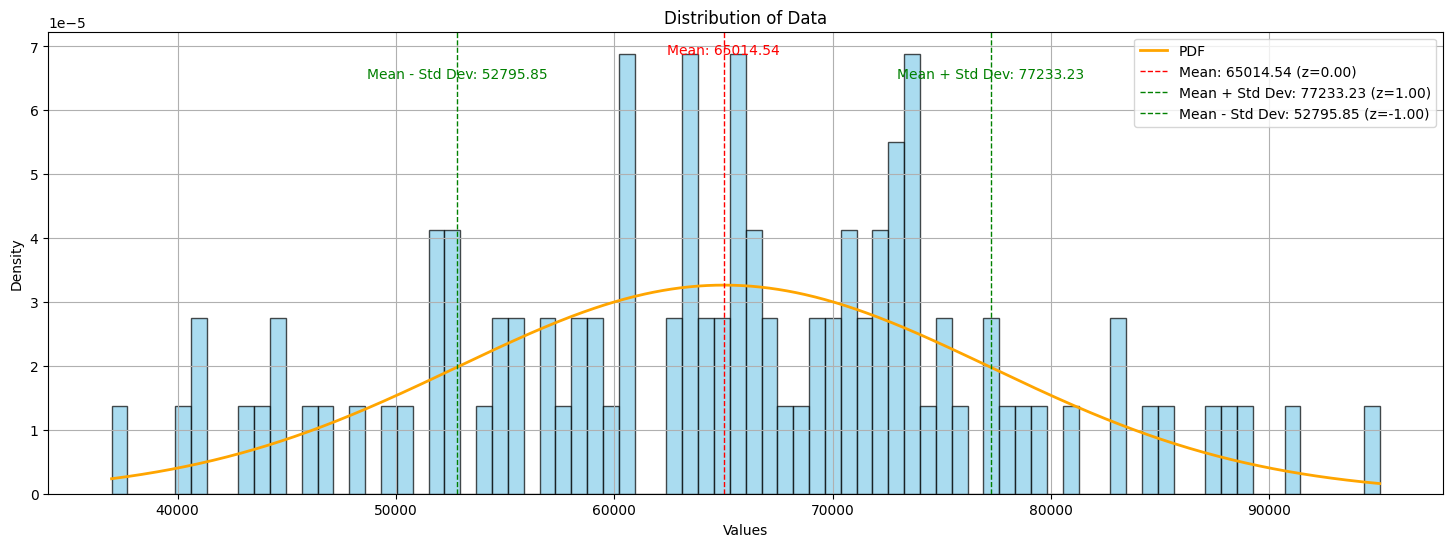

In [9]:
mean_value = np.mean(portResult)
std_dev = np.std(portResult)
kurtosis_value = stats.kurtosis(portResult)
skewness_value = stats.skew(portResult)

z_score_mean = 0
z_score_plus_std = 1
z_score_minus_std = -1

plt.figure(figsize=(18, 6))
plt.hist(portResult, bins=80, density=True, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Data')
plt.xlabel('Values')
plt.ylabel('Density')
plt.grid(True)

x = np.linspace(min(portResult), max(portResult), 1000)
pdf = stats.norm.pdf(x, mean_value, std_dev)
plt.plot(x, pdf, color='orange', linewidth=2, label='PDF')

plt.axvline(mean_value, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_value:.2f} (z={z_score_mean:.2f})')
plt.axvline(mean_value + std_dev, color='green', linestyle='dashed', linewidth=1, label=f'Mean + Std Dev: {mean_value + std_dev:.2f} (z={z_score_plus_std:.2f})')
plt.axvline(mean_value - std_dev, color='green', linestyle='dashed', linewidth=1, label=f'Mean - Std Dev: {mean_value - std_dev:.2f} (z={z_score_minus_std:.2f})')

plt.text(mean_value, plt.gca().get_ylim()[1]*0.95, f'Mean: {mean_value:.2f}', color='red', ha='center')
plt.text(mean_value + std_dev, plt.gca().get_ylim()[1]*0.9, f'Mean + Std Dev: {mean_value + std_dev:.2f}', color='green', ha='center')
plt.text(mean_value - std_dev, plt.gca().get_ylim()[1]*0.9, f'Mean - Std Dev: {mean_value - std_dev:.2f}', color='green', ha='center')


plt.legend()
plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">6. Skewness and Kurtosis of Portfolio



**Skewness** measures the asymmetry of a data distribution. If skewness is zero, the data is perfectly symmetric around the mean.  
Positive skewness means the right tail is longer or fatter, indicating more extreme high values.  
Negative skewness means the left tail is longer, showing more extreme low values.

**Kurtosis** measures the "tailedness" or how heavy the tails of a distribution are compared to a normal distribution.  
High kurtosis indicates more extreme outliers (heavy tails), while low kurtosis means fewer outliers and lighter tails.  
A normal distribution has a kurtosis of 3 (sometimes called mesokurtic).


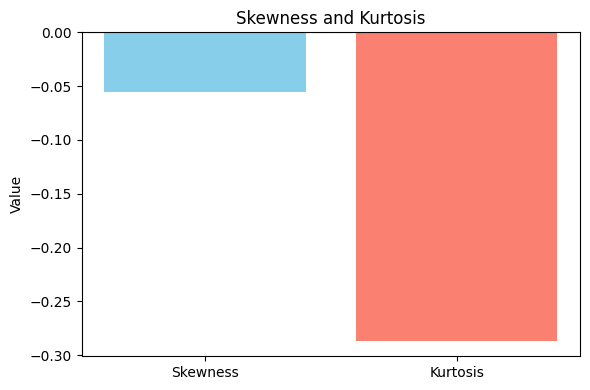

In [45]:
kurtosis_value = stats.kurtosis(portResult)
skewness_value = stats.skew(portResult)

labels = ['Skewness', 'Kurtosis']
values = [skewness_value, kurtosis_value]
colors_2 = ['skyblue', 'salmon']

plt.figure(figsize=(6, 4))
plt.bar(labels, values, color=colors_2)
plt.axhline(0, color='gray', linestyle='--', linewidth=0.8)
plt.title('Skewness and Kurtosis')
plt.ylabel('Value')
plt.tight_layout()
plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">7. Distribution of Returns and Volumes


<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">7.1 Distribution of Return of Stocks for the Investigated Period


AMC has the biggest Standard deviation in daily returns among the stocks in the list. Other stocks with high Standard deviation are NVDA and TSLA. In terms of standard Deviation SNPS and CDNS are identic. Negative mean or growth for the investigated period can see in TSLA and AMC.
Serious tails because of positive or negative tails can see on JPM and META

Only JPM has left skew showing that not all companies are extrively prfitable, 

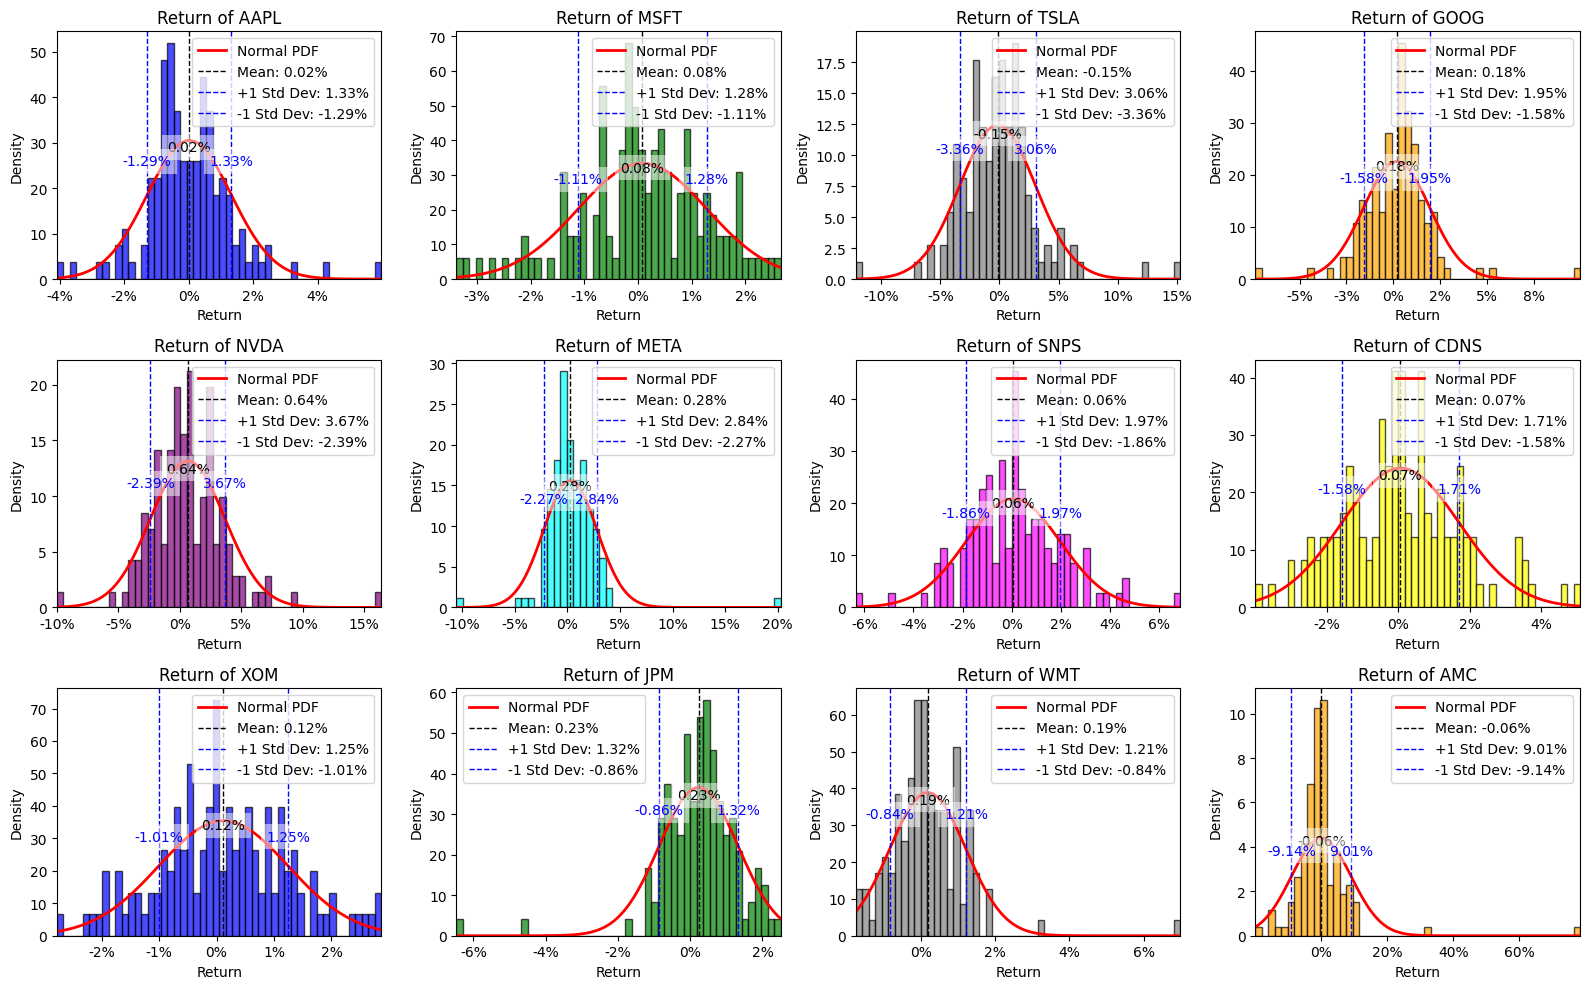

In [11]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=False) 

# Function to format the x-axis labels as percentages
def to_percent(y, position):
    return f'{y * 100:.0f}%'

for i, stock in enumerate(stocklist):
    row_index = i // 4
    col_index = i % 4
    stock_data = returns[stock]
    
    # Plotting the histogram for each stock with different colors
    axes[row_index, col_index].hist(stock_data, bins=50, color=colors[i % len(colors)], edgecolor='black', alpha=0.7, density=True)
    
    # Plotting PDF
    mean, std_dev = np.mean(stock_data), np.std(stock_data)
    min_range, max_range = stock_data.min(), stock_data.max()
    x = np.linspace(min_range, max_range, 100)
    pdf = norm.pdf(x, mean, std_dev)
    axes[row_index, col_index].plot(x, pdf, color='red', linestyle='-', linewidth=2, label='Normal PDF')
    
    # Adding vertical lines for mean and standard deviations
    mean_line = axes[row_index, col_index].axvline(mean, color='black', linestyle='--', linewidth=1, label=f'Mean: {mean:.2%}')
    std_dev_plus_line = axes[row_index, col_index].axvline(mean + std_dev, color='blue', linestyle='--', linewidth=1, label=f'+1 Std Dev: {mean + std_dev:.2%}')
    std_dev_minus_line = axes[row_index, col_index].axvline(mean - std_dev, color='blue', linestyle='--', linewidth=1, label=f'-1 Std Dev: {mean - std_dev:.2%}')
    
    # Adding text annotations for mean and standard deviation values
    axes[row_index, col_index].set_title(f'Return of {stock}')

    # Annotating the mean
    axes[row_index, col_index].text(mean, max(pdf) * 0.9, f'{mean:.2%}', color='black', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    # Annotating the standard deviations
    axes[row_index, col_index].text(mean + std_dev, max(pdf) * 0.8, f'{mean + std_dev:.2%}', color='blue', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    axes[row_index, col_index].text(mean - std_dev, max(pdf) * 0.8, f'{mean - std_dev:.2%}', color='blue', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    axes[row_index, col_index].set_xlabel('Return')
    axes[row_index, col_index].set_ylabel('Density')
    
    # Set x-axis limits based on data range
    axes[row_index, col_index].set_xlim(min_range, max_range)
    
    # Format the x-axis labels as percentages
    axes[row_index, col_index].xaxis.set_major_formatter(mticker.FuncFormatter(to_percent))
    
    # Adding legend
    axes[row_index, col_index].legend()

plt.tight_layout()
plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">7.2 Distribution of Volumes of Stocks in the Observation 


In the graphic below are observing Volume of trades of the stocks in period from 16 Nov 2023 to 6 Jun 2024

Higest volumes on the observed stocks means we see on NVDA, TSLA, AAPL, AMC. NVDA has day with even more than 1 bilion trade whcih can be seen on the thail of the PDF and visualising as outlier. 
For TSLA and AAPL is typical to have high volume as popular technological companies, we can see also Meme Stock AMC with the record mean of 31,65 and several dayly peaks of more thatn 300 millions traded stock, which is confusing for a company with market capitalisation of aprocimately 1.5 billion. The reason of this peiods of high trade is organised buying of big amount retail traders.

Extreme levels of Z-Score we have only in AMC where Standard deviation of Volume is 3 times bigger than Mean
In all volume distributions we have right skew with long tails which is simbolising that because of Q reports, good or bed news stocks register days with 3-4 times bigger than mean volumes which are again visualising as outlier and make tail of the PDF.

All stocks have positive skew of volumes of distribution


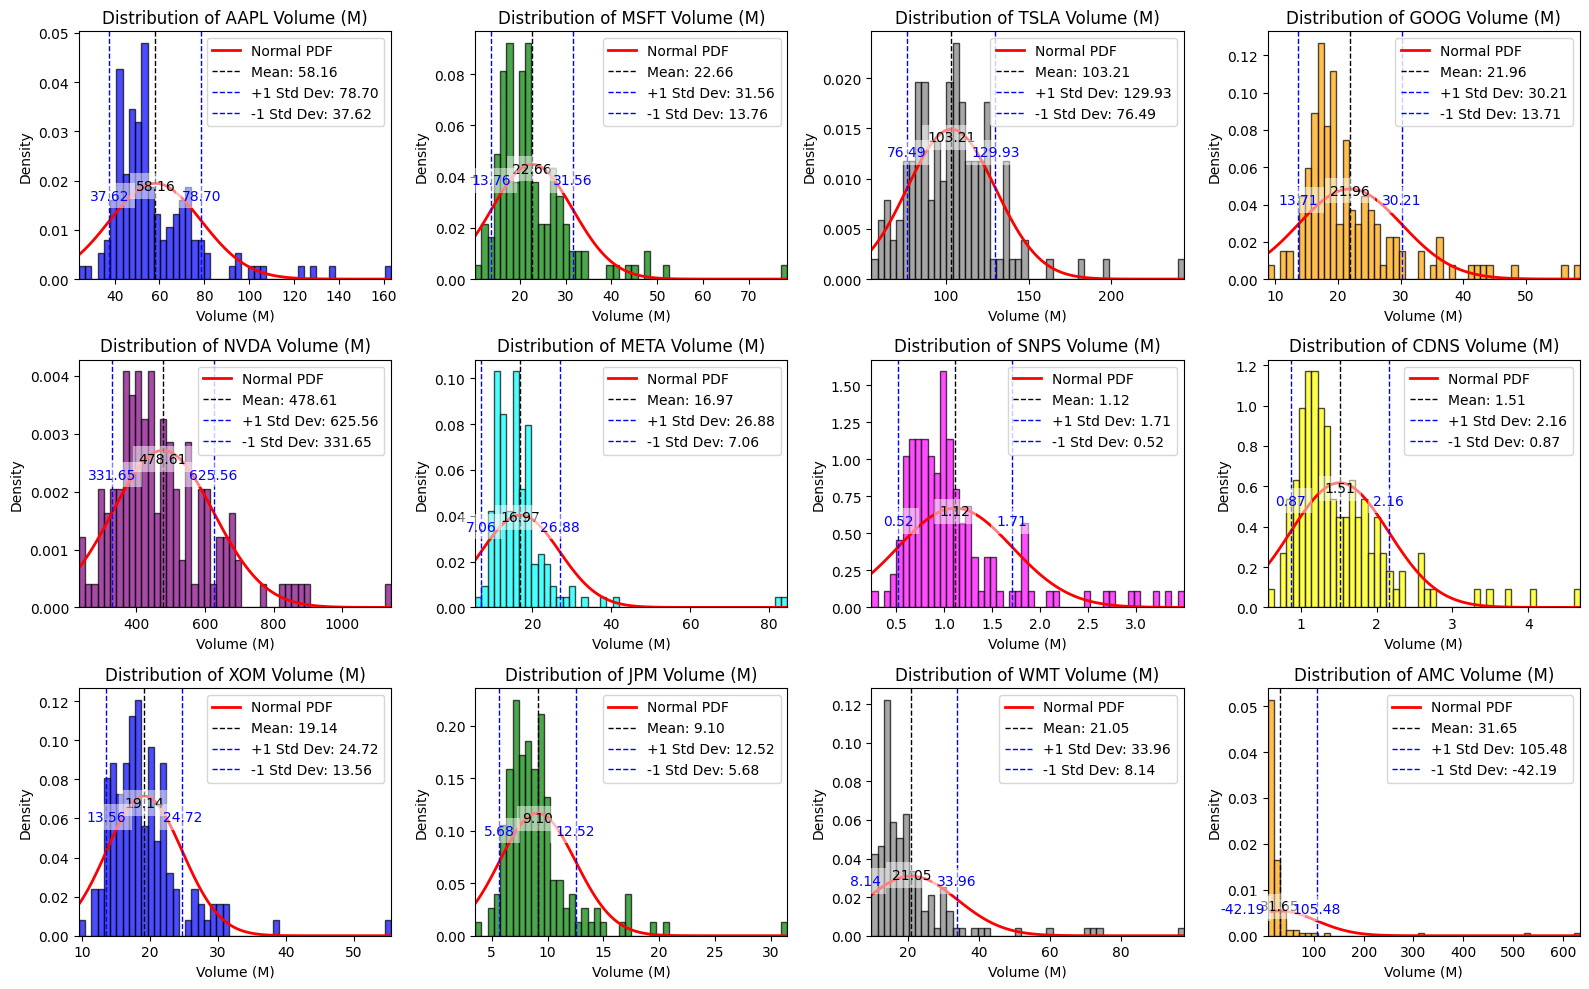

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 10), sharex=False)

for i, stock in enumerate(stocklist):
    row_index = i // 4
    col_index = i % 4
    stock_data = volume[stock] / 1e6  # Convert volume to millions
    
    # Plotting the histogram for each stock with different colors
    axes[row_index, col_index].hist(stock_data, bins=50, color=colors[i % len(colors)], edgecolor='black', alpha=0.7, density=True)
    
    # Plotting PDF
    mean, std_dev = np.mean(stock_data), np.std(stock_data)
    min_range, max_range = stock_data.min(), stock_data.max()
    x = np.linspace(min_range, max_range, 100)
    pdf = norm.pdf(x, mean, std_dev)
    axes[row_index, col_index].plot(x, pdf, color='red', linestyle='-', linewidth=2, label='Normal PDF')
    
    # Adding vertical lines for mean and standard deviations
    mean_line = axes[row_index, col_index].axvline(mean, color='black', linestyle='--', linewidth=1, label=f'Mean: {mean:.2f}')
    std_dev_plus_line = axes[row_index, col_index].axvline(mean + std_dev, color='blue', linestyle='--', linewidth=1, label=f'+1 Std Dev: {mean + std_dev:.2f}')
    std_dev_minus_line = axes[row_index, col_index].axvline(mean - std_dev, color='blue', linestyle='--', linewidth=1, label=f'-1 Std Dev: {mean - std_dev:.2f}')
    
    # Adding text annotations for mean and standard deviation values with background color
    axes[row_index, col_index].text(mean, max(pdf) * 0.9, f'{mean:.2f}', color='black', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    axes[row_index, col_index].text(mean + std_dev, max(pdf) * 0.8, f'{mean + std_dev:.2f}', color='blue', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    axes[row_index, col_index].text(mean - std_dev, max(pdf) * 0.8, f'{mean - std_dev:.2f}', color='blue', ha='center', va='bottom', bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    
    axes[row_index, col_index].set_title(f'Distribution of {stock} Volume (M)')
    axes[row_index, col_index].set_xlabel('Volume (M)')
    axes[row_index, col_index].set_ylabel('Density')
    
    # Set x-axis limits based on data range
    axes[row_index, col_index].set_xlim(min_range, max_range)
    
    # Adding legend
    axes[row_index, col_index].legend()

plt.tight_layout()
plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">8. Correlation Heatmap of Volume and Returns


In the Correlation Matrices below on first glance we can see CDNS have very strong linear relation of 0.82 with SNPS but relation on their volumes is not so strong - 0.42. SNPS and CDNS have good linear relation also with other stocks part of  AI revolution, which are observed in my work - MSFT and NVDA. 

It is interesting to see that in the investigated period GOOG and META whcih are from the same economic sector and main business is to sell advertisement has so small linear relation in terms of Returns -  0.27.

Other interesting insight from matrices are that XOM, WMT and JPM as a companies from diffrent sectors do not have any type of relation in returns except relation of 0.32 between JPM and WMT.

In my observation I included Meme Stock - AMC, it has clear negative correlation both on volumes and returns with other technical stocks in the list. That can be described as decision of tech investors to stay passive in periods of peaks of trading of mame Stocks.

Other negative correlation of returns we can see between XOM and tech stocks like NVDA, GOOD, MSFT, META whcih can be easily explained with fact that in economics when cash flow move to energy sector that means cash outflow from other tech and high risk sectors.

Based on the observation we can group stocks in three groups based on their results in correlation of return and volume - Tech, Conservative and Meme

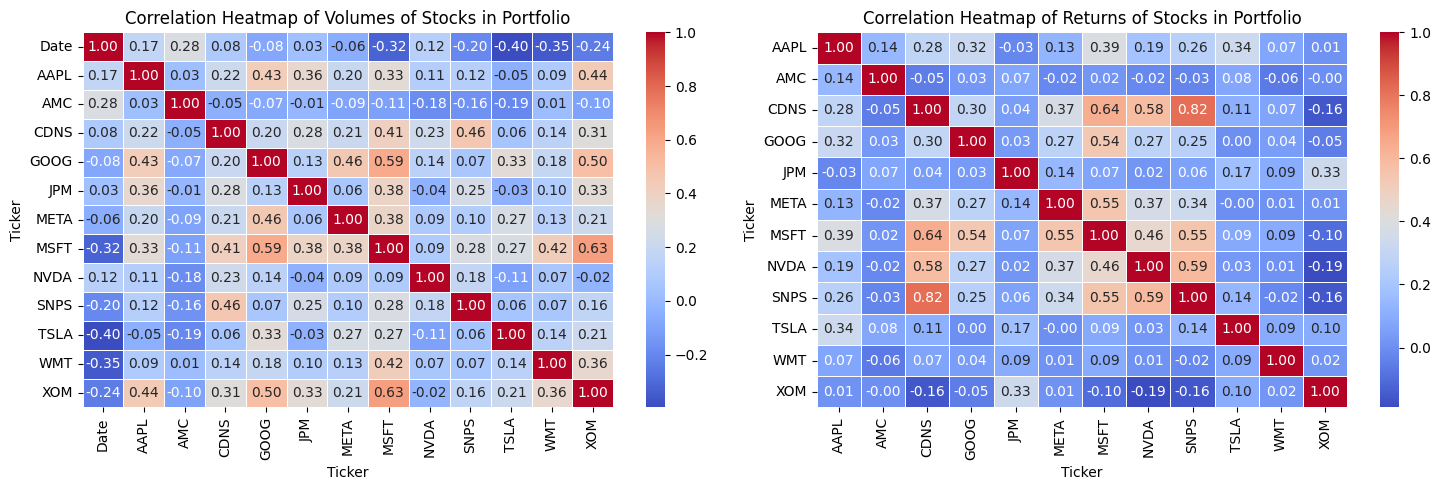

<Figure size 1000x900 with 0 Axes>

In [13]:
volume_corr_matrix, returns_corr_matrix = volume.corr(), returns.corr()

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot correlation heatmap for returns
sns.heatmap(returns_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axes[1])
axes[1].set_title('Correlation Heatmap of Returns of Stocks in Portfolio')

# Plot correlation heatmap for volume
sns.heatmap(volume_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, ax=axes[0])
axes[0].set_title('Correlation Heatmap of Volumes of Stocks in Portfolio')

plt.tight_layout()  
plt.figure(figsize=(10, 9))
plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">9. Probability - Value (One-sided P-Value) based on T-test

A one-sided p-value is used when your alternative hypothesis involves a "less than" (<) or "greater than" (>) comparison — you're only testing for an effect in one direction.

If the **p-value** is small (e.g., < 0.05),  **reject** \( H0 \) and conclude there's **significant evidence** that the **mean return is > 0**.


A small p-value (<0.05) means rejecting H0, so the stock has a statistically significant average return different from zero.

From the twelve equities analyzed, only three (JPM, NVDA, WMT) exhibit mean returns that differ
significantly from zero at the 5 % level. NVDA stands out with the highest average periodic
return (0.64 %), while TSLA and AMC have negative but statistically insignificant means.



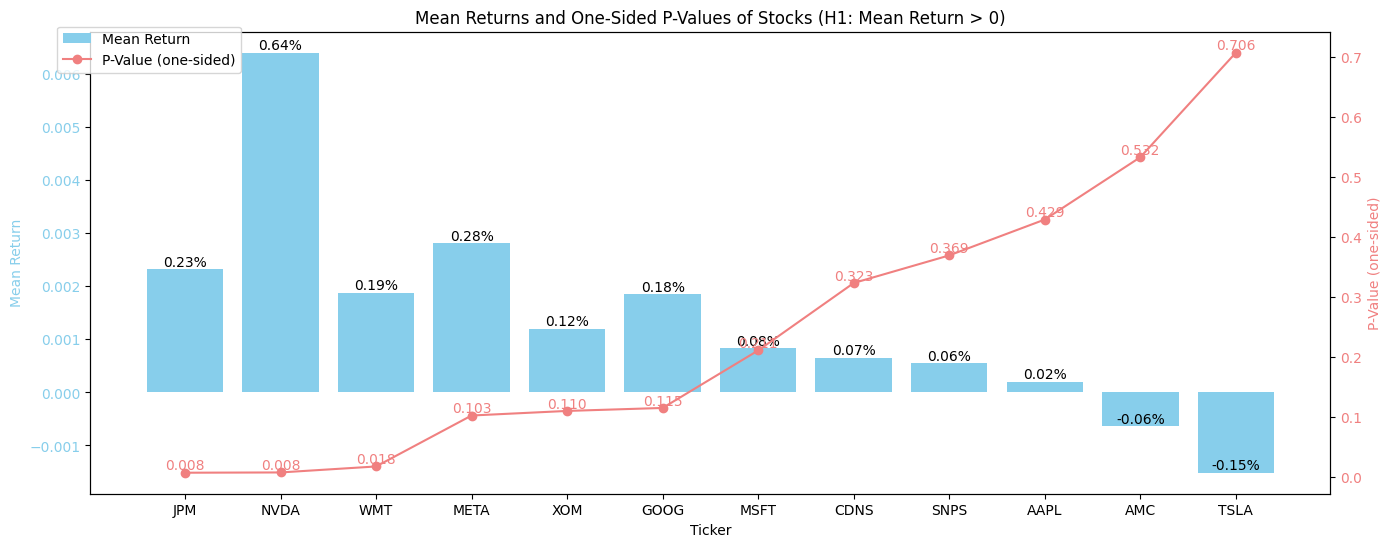

In [14]:
returns_simulations = pd.DataFrame(returns)
returns_simulations = returns_simulations.dropna()
returns_simulations.reset_index(inplace=True)
returns_simulations.set_index('Date', inplace=True)

tickers = returns_simulations.columns
mean_returns = []
p_values_one_sided = []

# Perform one-sided t-test (H1: mean return > 0) for each stock
for ticker in tickers:
    returns_values = returns_simulations[ticker].dropna()  # Ensure no NaN values
    mean_return = np.mean(returns_values)
    t_stat, p_two_sided = stats.ttest_1samp(returns_values, 0)
    # Convert two-sided p-value to one-sided for mean > 0
    if t_stat > 0:
        p_one_sided = p_two_sided / 2
    else:
        p_one_sided = 1 - (p_two_sided / 2)
    
    mean_returns.append(mean_return)
    p_values_one_sided.append(p_one_sided)

summary_df = pd.DataFrame({
    'Ticker': tickers,
    'Mean Return': mean_returns,
    'P-Value (one-sided)': p_values_one_sided
})

summary_df.sort_values(by='P-Value (one-sided)', ascending=True, inplace=True)

fig, ax1 = plt.subplots(figsize=(16, 6))

bars1 = ax1.bar(summary_df['Ticker'], summary_df['Mean Return'], color='skyblue', label='Mean Return')
ax1.set_xlabel('Ticker')
ax1.set_ylabel('Mean Return', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')

for bar, m_return in zip(bars1, summary_df['Mean Return']):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{m_return * 100:.2f}%', ha='center', va='bottom', color='black')

# Create a second y-axis to plot one-sided p-values as a line
ax2 = ax1.twinx()
line, = ax2.plot(summary_df['Ticker'], summary_df['P-Value (one-sided)'], color='lightcoral', marker='o', linestyle='-', label='P-Value (one-sided)')
ax2.set_ylabel('P-Value (one-sided)', color='lightcoral')
ax2.tick_params(axis='y', labelcolor='lightcoral')

for i, p_value in enumerate(summary_df['P-Value (one-sided)']):
    ax2.text(i, p_value, f'{p_value:.3f}', color='lightcoral', ha='center', va='bottom')

fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

plt.title('Mean Returns and One-Sided P-Values of Stocks (H1: Mean Return > 0)')
plt.show()


<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">10. Derivatives


<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">10.1 First Derivative of Stocks


Calculate the first derivative (difference between consecutive returns) to analyze the rate of change in returns for each stock.

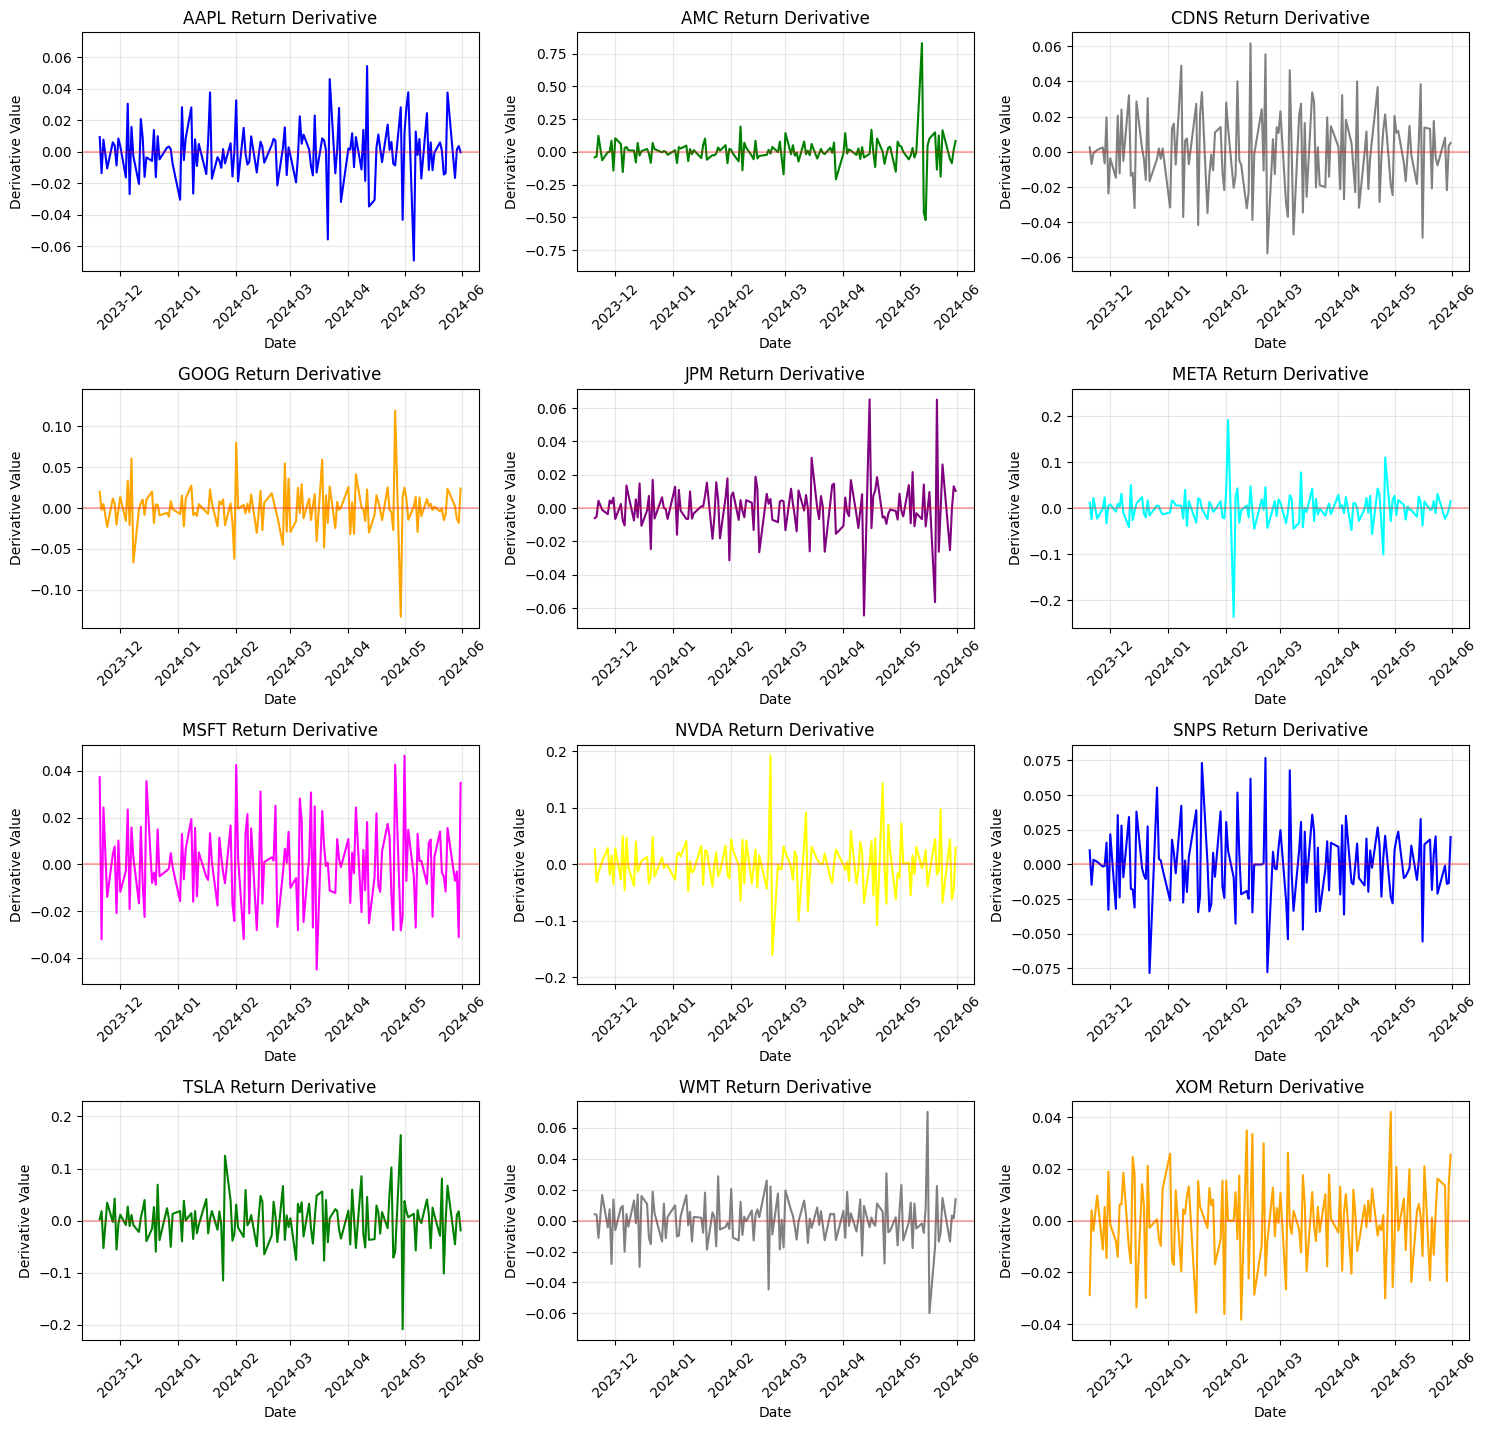

In [15]:
#Calculate the first derivative of returns
returns.index = pd.to_datetime(returns.index, errors='coerce')
first_derivatives = returns.diff().dropna()

plt.figure(figsize=(15, 15))

stocks = returns.columns

rows = 4
cols = 3

for i, stock in enumerate(stocks, 1):
    plt.subplot(rows, cols, i)
    
    # Get the derivative for this stock
    derivative = first_derivatives[stock]
    
    color_idx = (i - 1) % len(colors)
    
    plt.plot(derivative.index, derivative.values, label=f'{stock} Derivative', color=colors[color_idx])
    
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    plt.title(f'{stock} Return Derivative')
    plt.xlabel('Date')
    plt.ylabel('Derivative Value')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    y_abs_max = max(abs(derivative.min()), abs(derivative.max()))
    plt.ylim(-y_abs_max*1.1, y_abs_max*1.1)

plt.tight_layout(rect=[0, 0, 1, 0.96]) 

# Function to create a table of derivatives for each stock
def create_derivative_tables(derivatives_df):
     for stock in derivatives_df.columns:
        
         stock_data = derivatives_df[[stock]].reset_index()
         stock_data.columns = ['Date', 'Derivative']
        
         formatted_data = []
         for _, row in stock_data.iterrows():
             date_str = row['Date'].strftime('%Y-%m-%d')
             derivative_val = f"{row['Derivative']:.6f}"
             formatted_data.append((date_str, derivative_val))
        
create_derivative_tables(first_derivatives)

plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">10.2 Sum, Average, Standard Deviation of First Derivative


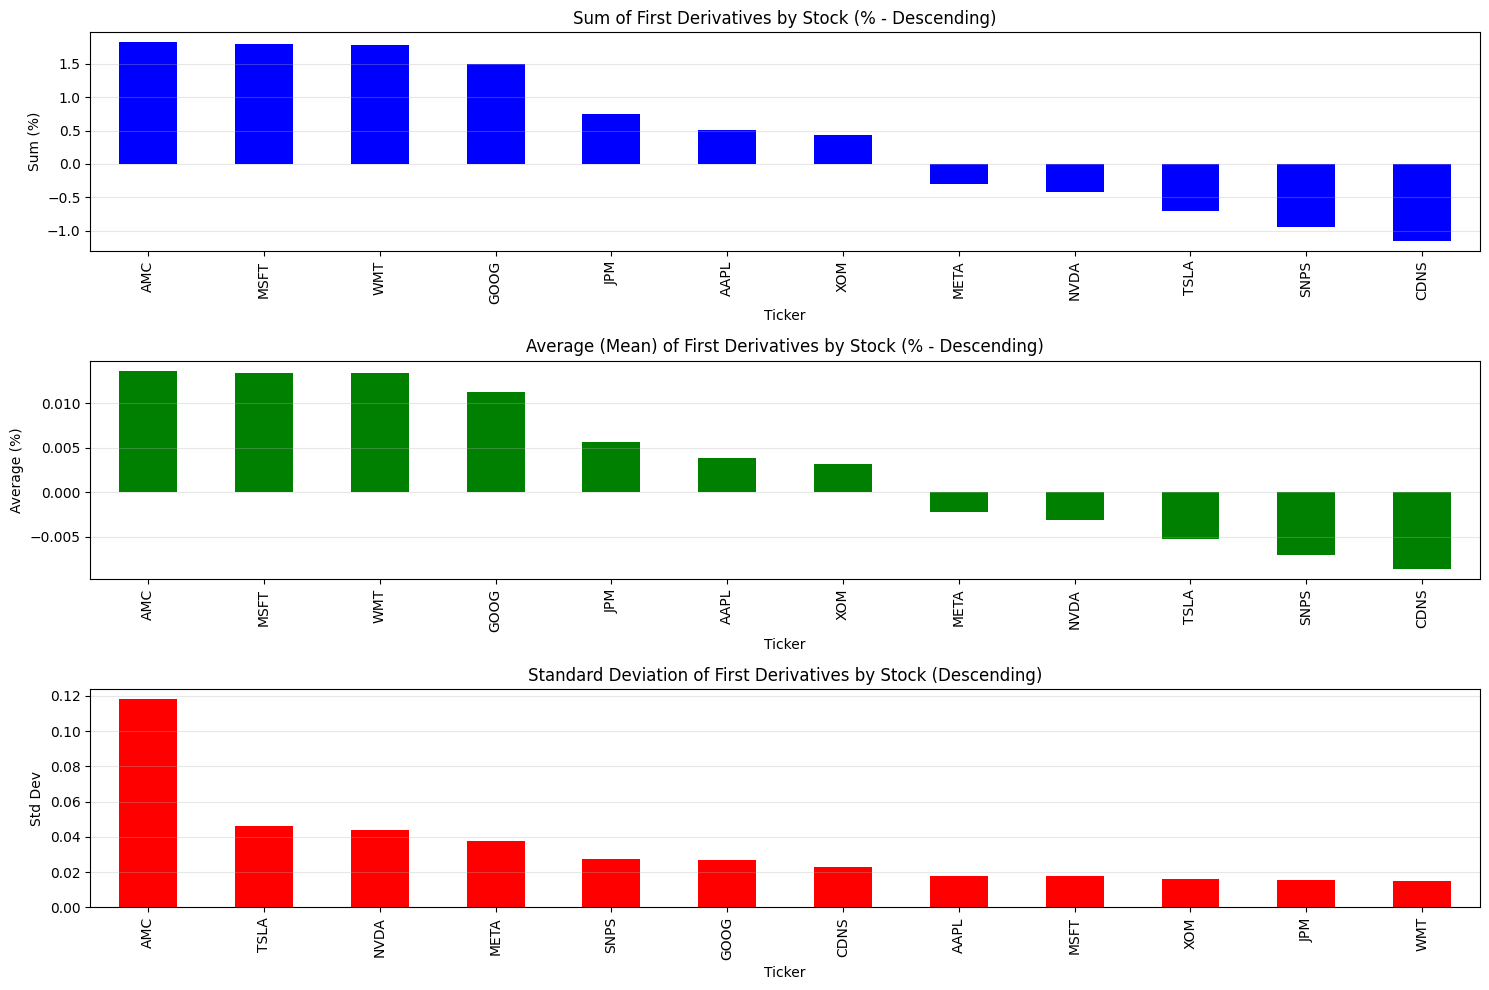

In [ ]:
sum_derivatives = first_derivatives.sum() * 100
avg_derivatives = first_derivatives.mean() * 100
std_derivatives = first_derivatives.std()

summary_stats = pd.DataFrame({
    'Sum (%)': sum_derivatives,
    'Average (%)': avg_derivatives,
    'Std Dev': std_derivatives
})

summary_stats_by_sum = summary_stats.sort_values('Sum (%)', ascending=False)
summary_stats_by_avg = summary_stats.sort_values('Average (%)', ascending=False)
summary_stats_by_std = summary_stats.sort_values('Std Dev', ascending=False)

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
summary_stats_by_sum['Sum (%)'].plot(kind='bar', color='blue')
plt.title('Sum of First Derivatives by Stock (% - Descending)')
plt.ylabel('Sum (%)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(3, 1, 2)
summary_stats_by_avg['Average (%)'].plot(kind='bar', color='green')
plt.title('Average (Mean) of First Derivatives by Stock (% - Descending)')
plt.ylabel('Average (%)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(3, 1, 3)
summary_stats_by_std['Std Dev'].plot(kind='bar', color='red')
plt.title('Standard Deviation of First Derivatives by Stock (Descending)')
plt.ylabel('Std Dev')
plt.grid(axis='y', alpha=0.3)

all_stocks_stats = {
    'Sum of All Derivatives (%)': first_derivatives.sum().sum() * 100,
    'Average of All Derivatives (%)': first_derivatives.mean().mean() * 100, 
    'Std Dev of All Derivatives': first_derivatives.values.flatten().std()
}

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">10.3 Second Derivative


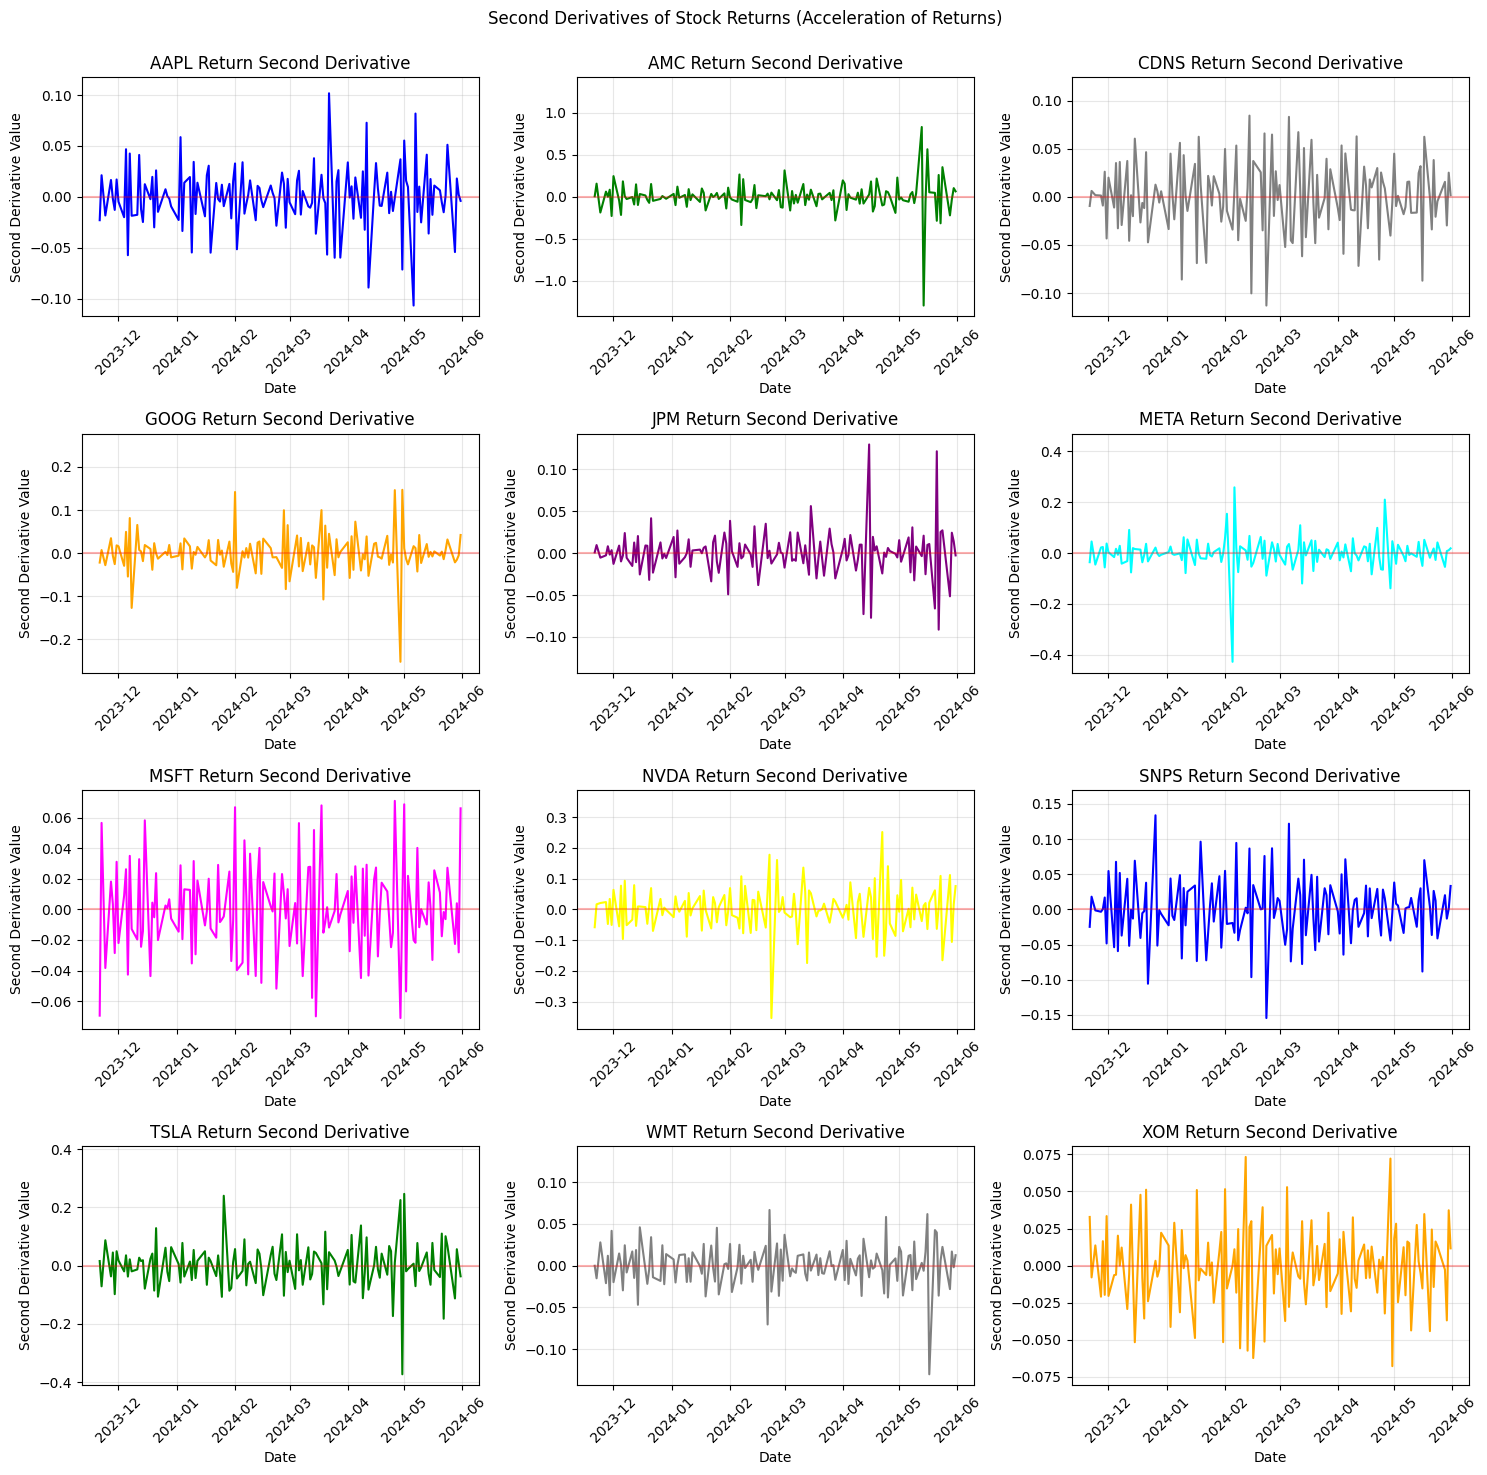

In [17]:
# Calculate second derivatives
second_derivatives = first_derivatives.diff().dropna()

plt.figure(figsize=(15, 15))

stocks = returns.columns

rows = 4
cols = 3

for i, stock in enumerate(stocks, 1):
    plt.subplot(rows, cols, i)
    
    # Get the second derivative for this stock
    second_derivative = second_derivatives[stock]
    
    color_idx = (i - 1) % len(colors)
    
    plt.plot(second_derivative.index, second_derivative.values, label=f'{stock} Second Derivative', color=colors[color_idx])
    
    plt.axhline(y=0, color='r', linestyle='-', alpha=0.3)
    
    plt.title(f'{stock} Return Second Derivative')
    plt.xlabel('Date')
    plt.ylabel('Second Derivative Value')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    y_abs_max = max(abs(second_derivative.min()), abs(second_derivative.max()))
    plt.ylim(-y_abs_max*1.1, y_abs_max*1.1)

plt.tight_layout(rect=[0, 0, 1, 0.96])  
plt.suptitle('Second Derivatives of Stock Returns (Acceleration of Returns)')

# Function to create a table of second derivatives for each stock
def create_second_derivative_tables(second_derivatives_df):
    for stock in second_derivatives_df.columns:
        
        stock_data = second_derivatives_df[[stock]].reset_index()
        stock_data.columns = ['Date', 'Second_Derivative']
        
        formatted_data = []
        for _, row in stock_data.iterrows():
            date_str = row['Date'].strftime('%Y-%m-%d')
            second_derivative_val = f"{row['Second_Derivative']:.6f}"
            formatted_data.append((date_str, second_derivative_val))
        
      
create_second_derivative_tables(second_derivatives)
plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">10.4 Sum, Average, Standard Deviation of Second Derivative


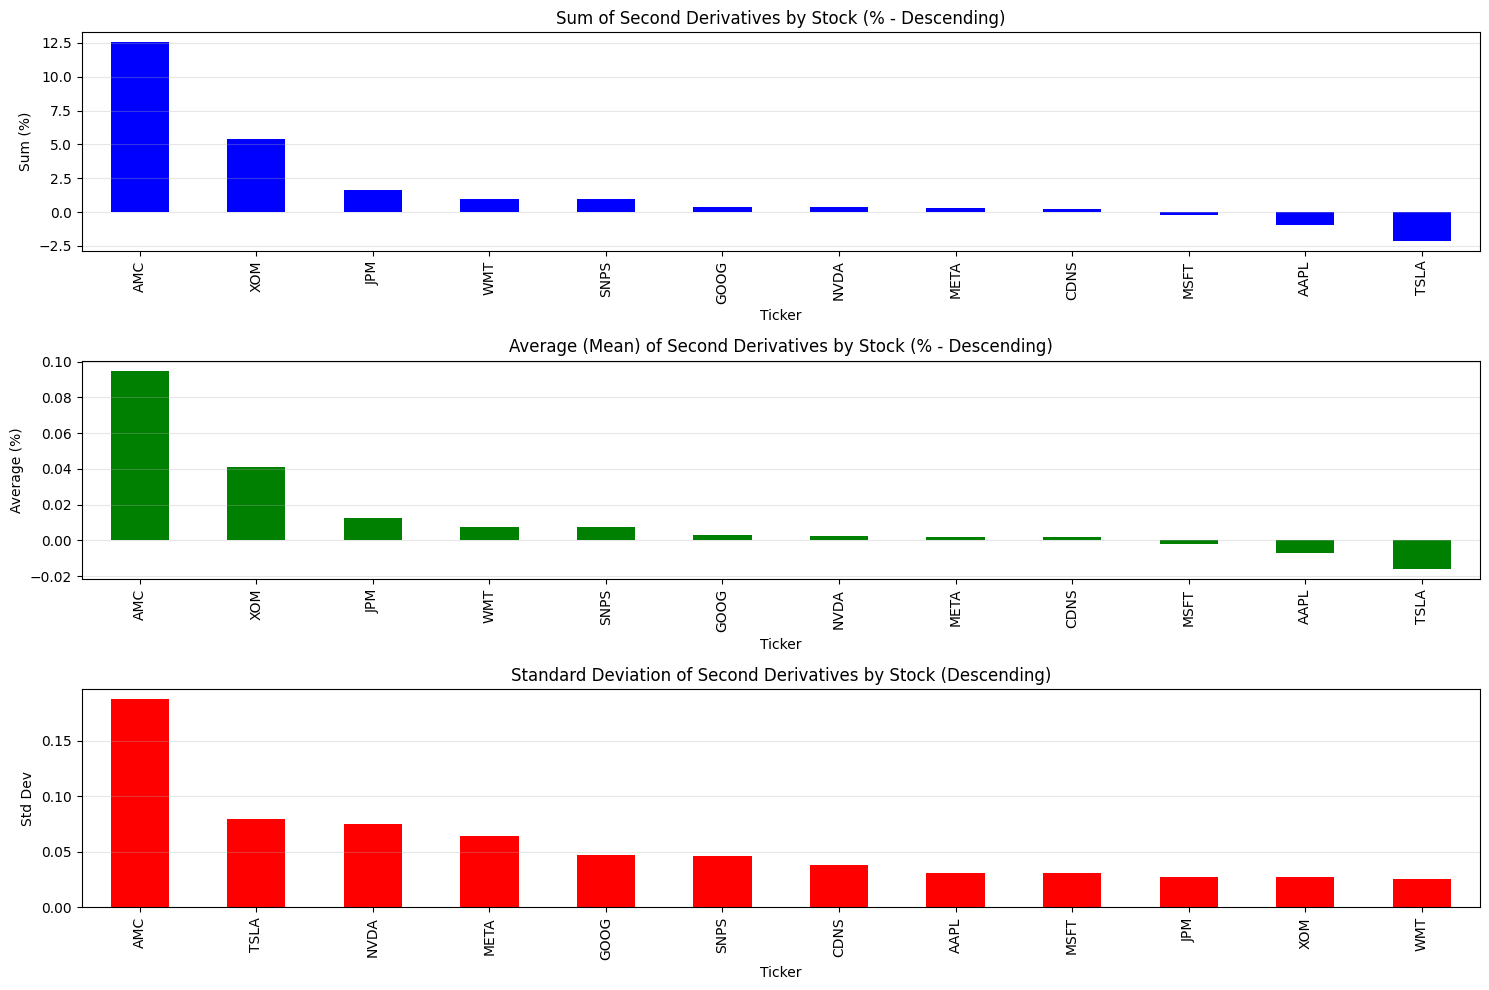

In [ ]:
sum_second_derivatives = second_derivatives.sum() * 100
avg_second_derivatives = second_derivatives.mean() * 100
std_second_derivatives = second_derivatives.std()

summary_stats = pd.DataFrame({
    'Sum (%)': sum_second_derivatives,
    'Average (%)': avg_second_derivatives,
    'Std Dev': std_second_derivatives
})

summary_stats_by_sum = summary_stats.sort_values('Sum (%)', ascending=False)
summary_stats_by_avg = summary_stats.sort_values('Average (%)', ascending=False)
summary_stats_by_std = summary_stats.sort_values('Std Dev', ascending=False)

plt.figure(figsize=(15, 10))

plt.subplot(3, 1, 1)
summary_stats_by_sum['Sum (%)'].plot(kind='bar', color='blue')
plt.title('Sum of Second Derivatives by Stock (% - Descending)')
plt.ylabel('Sum (%)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(3, 1, 2)
summary_stats_by_avg['Average (%)'].plot(kind='bar', color='green')
plt.title('Average (Mean) of Second Derivatives by Stock (% - Descending)')
plt.ylabel('Average (%)')
plt.grid(axis='y', alpha=0.3)

plt.subplot(3, 1, 3)
summary_stats_by_std['Std Dev'].plot(kind='bar', color='red')
plt.title('Standard Deviation of Second Derivatives by Stock (Descending)')
plt.ylabel('Std Dev')
plt.grid(axis='y', alpha=0.3)

all_stocks_stats = {
    'Sum of All Second Derivatives (%)': second_derivatives.sum().sum() * 100,
    'Average of All Second Derivatives (%)': second_derivatives.mean().mean() * 100, 
    'Std Dev of All Second Derivatives': second_derivatives.values.flatten().std()
}

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">11. Principal Component Analysis

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">11.1. PCA of Stock Returns: First Two Principal Components


The plot projects each stock’s **daily‑return time series** onto the first two principal components:

* **PC 1 (x‑axis)** – captures 29.9 % of total variance  
  *Positive scores* → stocks that move with the dominant market factor.  
  *Negative scores* → stocks that tend to move opposite that factor.

* **PC 2 (y‑axis)** – captures an additional 12.8 % 
  Separates stocks by a secondary, independent pattern.


| Quadrant | PC 1 sign | PC 2 sign | Typical interpretation |
|----------|-----------|-----------|------------------------|
| **Q1**  | + | + | Stocks aligned with both dominant factors → often large‑cap growth/tech leaders. |
| **Q2**   | – | + | Hedge/energy names that oppose the market factor yet share the secondary pattern. |
| **Q3**   | – | – | Assets moving opposite on both axes → defensive or idiosyncratic plays. |
| **Q4**  | + | – | High exposure to the market factor but opposite reaction to PC 2 nuance. |

Together PC 1 + PC 2 explain **≈ 42.7 %** of the variation across all stocks, giving a concise 2‑D map of return behaviour.


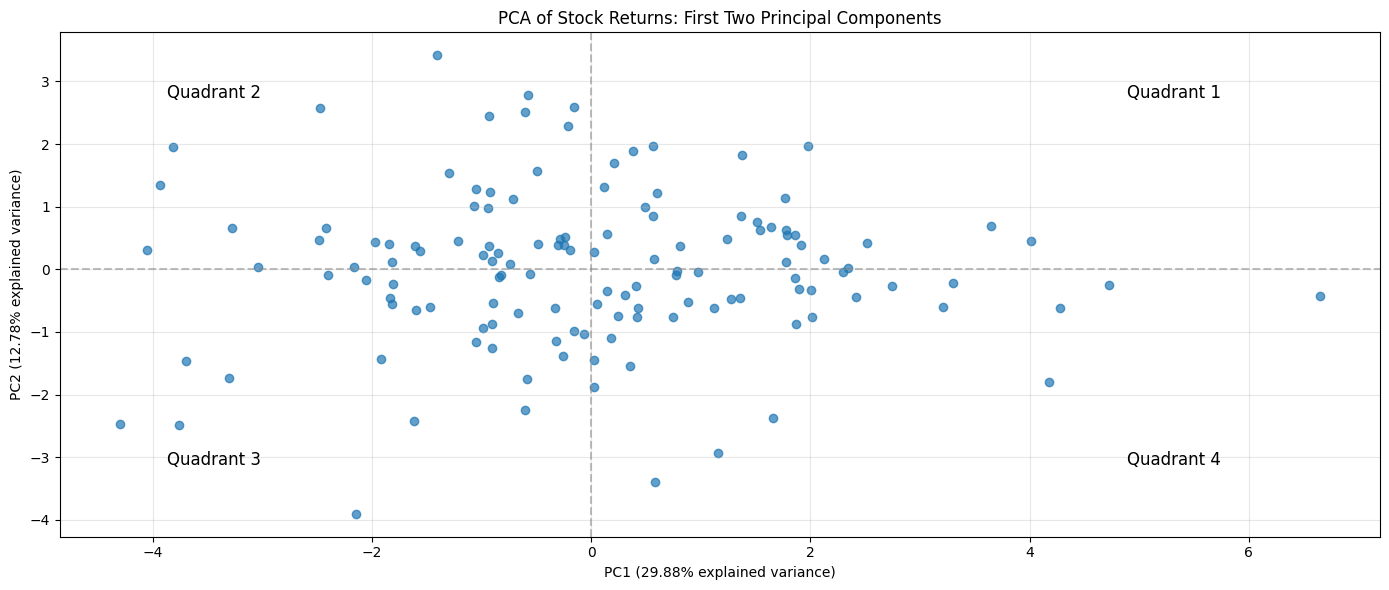

In [19]:
#Calculations
df_clean = returns.dropna()

scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_clean)

pca = PCA() #keep original count of columns
pca_result = pca.fit_transform(scaled_data) #Fits the PCA model on the standardized data and transforms it.

#Converts the PCA results into a DataFrame called pca_df.
pca_df = pd.DataFrame(
    data=pca_result,
    columns=[f'PC{i+1}' for i in range(pca_result.shape[1])],
    index=df_clean.index
)

explained_variance = pca.explained_variance_ratio_ #Extracts the proportion of the dataset’s variance explained by each principal component.
cumulative_variance = np.cumsum(explained_variance) #Computes the cumulative variance explained by the components.

#Ploting PCA Results
plt.figure(figsize=(14, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], alpha=0.7)

plt.axhline(y=0, color='grey', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)

plt.text(pca_df['PC1'].max()*0.8, pca_df['PC2'].max()*0.8, 'Quadrant 1', fontsize=12, ha='center')
plt.text(pca_df['PC1'].min()*0.8, pca_df['PC2'].max()*0.8, 'Quadrant 2', fontsize=12, ha='center')
plt.text(pca_df['PC1'].min()*0.8, pca_df['PC2'].min()*0.8, 'Quadrant 3', fontsize=12, ha='center')
plt.text(pca_df['PC1'].max()*0.8, pca_df['PC2'].min()*0.8, 'Quadrant 4', fontsize=12, ha='center')

plt.title('PCA of Stock Returns: First Two Principal Components')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} explained variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} explained variance)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">11.2. PCA Loading Plot: Contribution of Each Stock to PC1 and PC2



| Region (signs) | Stocks located there | Take‑away |
|----------------|----------------------|-----------|
| **(+ PC1, + PC2)** upper‑right | AAPL, GOOG, META, MSFT, TSLA, JPM | Move **with** both dominant factors → large‑cap growth/tech plus JPM |
| **(– PC1, + PC2)** upper‑left | XOM | Opposite the tech‑heavy PC 1, but high on PC 2 → energy behaves differently from tech momentum |
| **(+ PC1, – PC2)** lower‑right | NVDA, SNPS, CDNS | Strong tech momentum (PC 1) but *opposite* reaction to PC 2 nuance |
| **Near origin** | AMC, WMT | Weak loadings on both PCs → idiosyncratic or explained by later components |


* **Sector insight** – Tech stocks cluster on the right; energy (XOM) sits on the left, highlighting sector‑driven variance.
* **Diversification ideas** – Pairing opposites along PC 1 (e.g., long MSFT / long XOM) naturally hedges the dominant factor.
* **Dimensionality reduction** – Retaining only PC 1 and PC 2 compresses the feature space to two orthogonal factors while keeping ~43 % of information.
* **Further analysis** – Inspect PCs 3 + 4 if you require ≥ 70–80 % cumulative variance for downstream models.

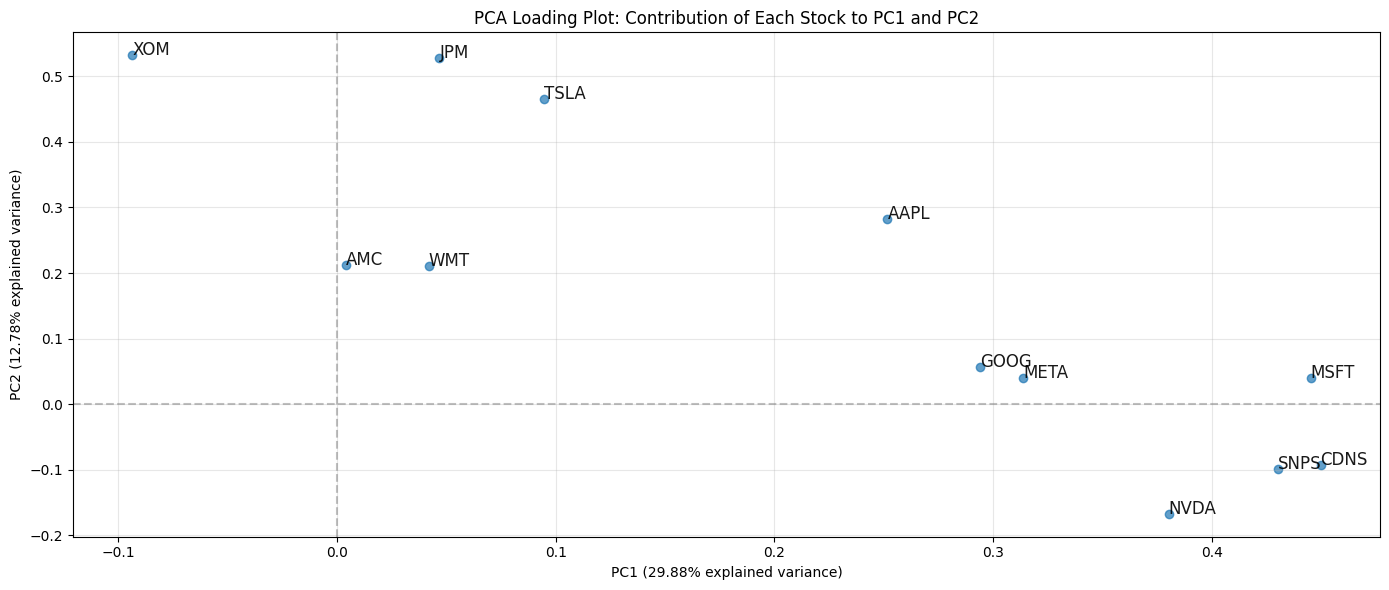

In [20]:
plt.figure(figsize=(14, 6))
loadings = pca.components_.T

# Plot the loadings for PC1 and PC2
loading_df = pd.DataFrame(
    loadings,
    columns=[f"PC{i+1}" for i in range(loadings.shape[1])],
    index=df_clean.columns,
)
plt.scatter(loading_df['PC1'], loading_df['PC2'], alpha=0.7)

for i, stock in enumerate(loading_df.index):
    plt.annotate(stock, (loading_df['PC1'].iloc[i], loading_df['PC2'].iloc[i]), 
                 fontsize=12, alpha=0.9)

plt.axhline(y=0, color='grey', linestyle='--', alpha=0.5)
plt.axvline(x=0, color='grey', linestyle='--', alpha=0.5)

plt.title('PCA Loading Plot: Contribution of Each Stock to PC1 and PC2')
plt.xlabel(f'PC1 ({explained_variance[0]:.2%} explained variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} explained variance)')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">11.3. Cumulative Explained Variance by Principal Components


This plot shows the cumulative explained variance from PCA, helping visualize how much information is retained as principal components are added. Horizontal lines at 80% and 90% indicate thresholds commonly used to decide the optimal number of components. It helps guide dimensionality reduction decisions.


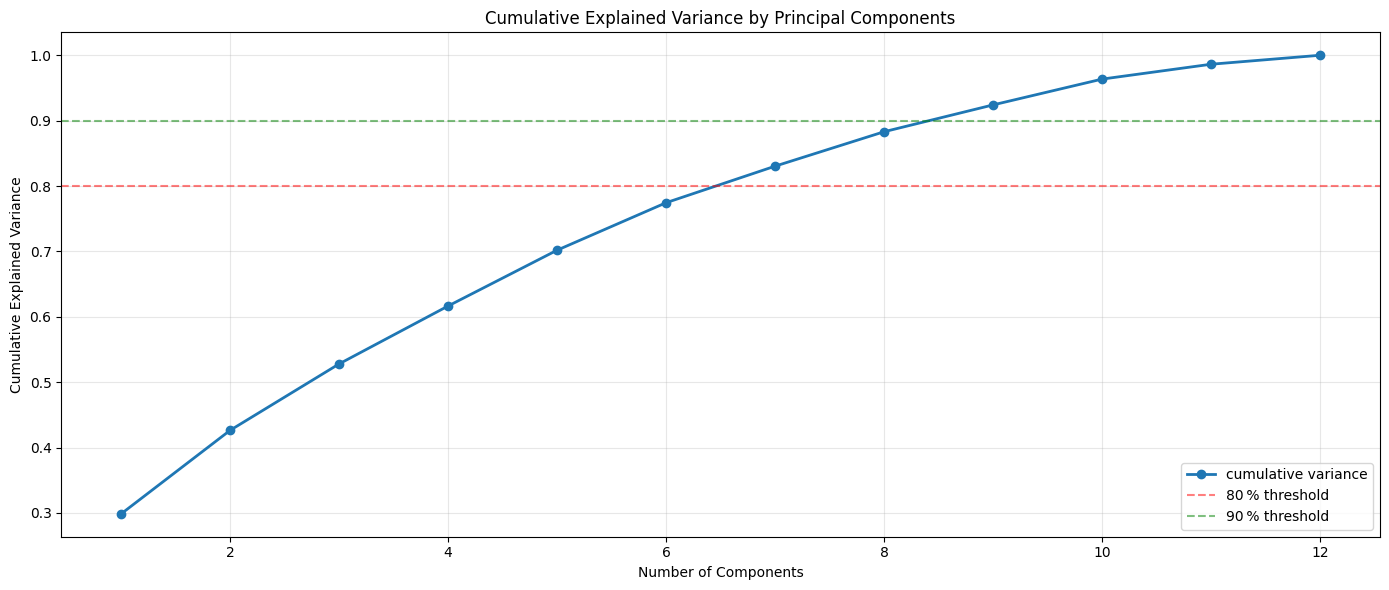

In [21]:
plt.figure(figsize=(14, 6))

# Cumulative variance curve
plt.plot(
    range(1, len(cumulative_variance) + 1),
    cumulative_variance,
    'o-',
    linewidth=2,
    label='cumulative variance'         
)

# Reference lines
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.5,
            label='80 % threshold')      
plt.axhline(y=0.9, color='g', linestyle='--', alpha=0.5,
            label='90 % threshold')      

plt.legend(loc='lower right')            
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12. Black–Scholes Model


The **Black-Scholes model** is a mathematical model used to determine the **fair price of European options** — financial contracts that give the right (but not the obligation) to buy or sell an asset at a set price on a specific future date.

- The stock price evolves **randomly over time** (modeled as a continuous stochastic process).
- It's possible to construct a **risk-free portfolio** by combining the option and its underlying asset.
- Assuming **no arbitrage**, the option price must satisfy a certain mathematical relationship.

---
Key Assumptions

- No transaction costs or taxes.
- Continuous trading is possible.
- Constant and known risk-free interest rate.
- Constant volatility of the underlying asset.
- The option is **European** (exercisable only at expiration).

Mathematical Tools Used

- **Stochastic calculus** (Brownian motion)
- **Partial differential equations (PDEs)**
- **Probability theory** 


![Black-Scholes Model](Black_Scholes_Model.jpg)


<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12.1 Global variables to store data


# Black-Scholes Model Variables

- **`stock_data`**  
  Contains historical or current data for the underlying stock, such as prices, volume, and other relevant financial information. This data is often used to derive parameters like volatility.

- **`current_price`**  
  The current market price of the underlying asset (e.g., the stock price). This is the spot price used in the Black-Scholes formula.

- **`volatility`**  
  The measure of the stock’s price fluctuations over time, typically expressed as the annualized standard deviation of the stock’s returns. It represents the uncertainty or risk about the stock’s future price.

- **`risk_free_rate`**  
  The theoretical rate of return on an investment with zero risk, often approximated by government treasury bond yields. It’s used as the discount rate in the Black-Scholes formula.

- **`ticker`**  
  The stock symbol or identifier for the underlying asset, e.g., "AAPL" for Apple Inc.

- **`option_expirations`**  
  The available expiration dates for the options contracts on the underlying stock. These dates indicate when the option contract expires and is the timeframe over which the option's price is evaluated.


In [ ]:
#Define Global Variables
stock_data = None
current_price = None
volatility = None
risk_free_rate = None
ticker = None
option_expirations = None

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12.2 Fetch real stock data from yfinance


In [23]:
def fetch_stock_data(symbol=None, period="1y"):
    global stock_data, current_price, ticker, option_expirations

    ticker = yf.Ticker(symbol)
    stock_data = ticker.history(period=period) #Downloads the stock's historical price data 
    current_price = stock_data['Close'].iloc[-1] #Extracts the most recent closing price from the Close
    option_expirations = ticker.options   # Get available option expiration dates

    print(f"Current Price: ${current_price:.2f}")

    return True

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12.3 Calculate historical volatility


In [24]:
def calculate_volatility(method='historical'):
    global volatility
    
    if stock_data is None:
        return None
    
    if method == 'historical':
        returns = np.log(stock_data['Close'] / stock_data['Close'].shift(1)).dropna() # Calculate daily returns
        volatility = returns.std() * np.sqrt(252) # Annualized volatility (252 trading days)
    elif method == 'garch':  # Could implement GARCH model here for more sophisticated volatility estimation
        pass
    
    print(f"Historical Volatility: {volatility:.4f} ({volatility*100:.2f}%)")
    return volatility

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12.4 Fetch Risk-free rate from Treasury data


In [25]:
def fetch_risk_free_rate():
    global risk_free_rate
    
    treasury = yf.Ticker("^TNX")     # Fetch 10-year Treasury yield as proxy for risk-free rate
    treasury_data = treasury.history(period="5d")
    risk_free_rate = treasury_data['Close'].iloc[-1] / 100  
    print(f"Current 10Y Treasury Rate: {risk_free_rate:.4f} ({risk_free_rate*100:.2f}%)")

    return risk_free_rate

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12.5 Fetch real option chain data from yfinance


An option chain (also known as an options matrix) is a table or dataset that lists all available call and put option contracts for a specific stock (or other underlying asset) at a given expiration date.

###  Common Columns in an Option Chain

| **Field**                 | **Meaning**                                                                 |
|---------------------------|-----------------------------------------------------------------------------|
| **Strike**                | The price at which the option can be exercised.                             |
| **Last Price**            | The most recent traded price of the option.                                 |
| **Bid**                   | The highest price a buyer is willing to pay.                                |
| **Ask**                   | The lowest price a seller is asking for.                                    |
| **Volume**                | Number of contracts traded during the current day.                          |
| **Open Interest**         | Total number of outstanding option contracts.                               |
| **Implied Volatility (IV)** | Market's expectation of volatility; higher IV means higher premium.         |
| **Delta, Gamma, Theta, Vega** | "Greeks" – sensitivities to various risk factors. (Optional, not always shown) |


In [26]:
def fetch_real_option_data(expiration_date=None):
    if ticker is None or not option_expirations:
        print("No stock data available. Please fetch stock data first.")
        return None

    # Use the nearest expiration if none specified
    if expiration_date is None:
        expiration_date = option_expirations[0]
    elif expiration_date not in option_expirations:
        print(f"Expiration {expiration_date} not available. Using {option_expirations[0]}")
        expiration_date = option_expirations[0]

    # Fetch option chain
    option_chain = ticker.option_chain(expiration_date)
    calls_df = option_chain.calls
    puts_df = option_chain.puts

    # Calculate time to expiration
    exp_date = datetime.strptime(expiration_date, '%Y-%m-%d')
    time_to_expiry = (exp_date - datetime.now()).days / 365.25

    print(f"Fetched option data for {expiration_date}")
    print(f"Time to expiration: {(time_to_expiry*365):.0f} days")
    print(f"Call options: {len(calls_df)}, Put options: {len(puts_df)}")

    return {
        'calls': calls_df,
        'puts': puts_df,
        'expiration': expiration_date,
        'time_to_expiry': time_to_expiry
    }


<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12.6 Calculate Black-Scholes option price (using Black-Scholes formula)


d1 and d2 are used to compute the probability that the option will expire in the money, but adjusted for time value and risk.

- **d1**  Represents how far the current stock price is above the strike price, adjusted for time, risk, and volatility. It relates to the option’s sensitivity to the stock price.

- **d2**  Represents the probability (under a risk-neutral world) that the option will expire in-the-money. It is slightly less than d1, accounting for expected volatility over time.

- Both are used to calculate the option price through probabilities from the normal distribution.


In [27]:
def black_scholes_price(strike_price, time_to_expiry, option_type='call'):
    S = current_price      # Current stock price
    K = strike_price       # Strike price
    T = time_to_expiry    # Time to expiration
    r = risk_free_rate    # Risk-free rate
    sigma = volatility    # Volatility
    
    if T <= 0:
        # Handle expired options
        if option_type.lower() == 'call':
            return max(S - K, 0), 0, 0
        else:
            return max(K - S, 0), 0, 0
    
    # Calculate d1 and d2
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    if option_type.lower() == 'call':
        price = S*norm.cdf(d1) - K*np.exp(-r*T)*norm.cdf(d2)
    elif option_type.lower() == 'put':
        price = K*np.exp(-r*T)*norm.cdf(-d2) - S*norm.cdf(-d1)
    else:
        raise ValueError("option_type must be 'call' or 'put'")
    
    return price, d1, d2

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12.7 Calculate option Greeks


These Greeks measure how sensitive an option’s price is to variables. They help understand risk and how option prices might change.
- The **Greeks** are derived by taking partial derivatives of the option pricing function, which itself is the **solution to a differential equation** (the Black-Scholes PDE).
- Thus, the calculation of Greeks **fundamentally depends on differential equations**.

---

### 1. Delta (Δ)
- **What it measures:** How much the option price moves when the price of the underlying asset changes.
- **Example:** If Delta is 0.6, and the underlying stock goes up by $1, the option price will go up by about $0.60.
- **Note:**  
  - Call options have positive Delta (price goes up with the stock).  
  - Put options have negative Delta (price goes down when the stock goes up).

---

### 2. Gamma (Γ)
- **What it measures:** How much Delta changes when the price of the underlying asset changes.
- **Why it matters:** It tells you how stable Delta is. A high Gamma means Delta will change a lot when the stock price moves, so your option’s sensitivity is shifting quickly.

---

### 3. Theta (Θ)
- **What it measures:** How much the option price decreases as time passes.
- **Why it matters:** Options lose value as expiration gets closer (called "time decay"). Theta shows how fast this happens.
- **Typical sign:** Negative — options usually lose value over time if all else stays the same.

---

### 4. Vega (ν)
- **What it measures:** How much the option price changes when the volatility of the underlying asset changes.
- **Why it matters:** Higher volatility means more chance of big moves, which generally makes options more valuable. Vega tells you how sensitive the option price is to changes in volatility.

---

### 5. Rho (ρ)
- **What it measures:** How much the option price changes when the risk-free interest rate changes.
- **When it matters:** Mostly for longer-term options. If interest rates rise, call options usually get more expensive.




In [28]:
def calculate_greeks(strike_price, time_to_expiry, option_type='call'):
    S = current_price
    K = strike_price
    T = time_to_expiry
    r = risk_free_rate
    sigma = volatility
    
    d1 = (np.log(S/K) + (r + 0.5*sigma**2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    # 1 Delta
    if option_type.lower() == 'call':
        delta = norm.cdf(d1)
    else:
        delta = norm.cdf(d1) - 1
    
    # 2 Gamma
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T)) # use the formula obtained by solving the DE and then differentiating the solution.
    
    # 3 Theta
    if option_type.lower() == 'call':
        theta = (-S*norm.pdf(d1)*sigma/(2*np.sqrt(T)) - 
                r*K*np.exp(-r*T)*norm.cdf(d2)) / 365
    else:
        theta = (-S*norm.pdf(d1)*sigma/(2*np.sqrt(T)) + 
                r*K*np.exp(-r*T)*norm.cdf(-d2)) / 365
    
    # 4 Vega
    vega = S * norm.pdf(d1) * np.sqrt(T) / 100
    
    # Rho
    if option_type.lower() == 'call':
        rho = K * T * np.exp(-r*T) * norm.cdf(d2) / 100
    else:
        rho = -K * T * np.exp(-r*T) * norm.cdf(-d2) / 100
    
    return {
        'delta': delta,
        'gamma': gamma,
        'theta': theta,
        'vega': vega,
        'rho': rho
    }

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12.8 Calculate implied volatility using Newton-Raphson method


- Implied Volatility (IV) is the market’s expectation of how much the price of the underlying asset will move in the future.
- Unlike historical volatility (which looks at past price movements), implied volatility is derived from the current market price of an option.
- It tells you how “volatile” the market thinks the underlying will be over the life of the option.
- Newton-Raphson - root-finding algorithm based on which is calculating Implied Volatility (IV)

### Newton-Raphson Parameters for Implied Volatility (IV)

### 1. Initial Guess
- A starting value for volatility (usually around 0.2 or 20%).
- A good guess can lead to faster and more stable convergence.

### 2. Tolerance
- The acceptable level of error between the model price and the market price.
- Determines when to stop the iteration (e.g., when the difference is very small).

### 3. Maximum Iterations
- A safety limit to prevent infinite loops if the method doesn't converge.
- Common default is 100 iterations.

### 4. Option Pricing Function
- Calculates the theoretical price of an option given a volatility.
- Compares this price to the actual market price.

### 5. Derivative of the Pricing Function (Vega)
- Measures how sensitive the option price is to changes in volatility.
- Used to adjust the guess in each iteration step.

### 6. Convergence Criteria
- A combination of tolerance and maximum iterations.
- The algorithm stops when the price difference is within tolerance or when it hits the iteration limit.


In [29]:
def calculate_implied_volatility(market_price, strike_price, time_to_expiry, option_type='call'):
    global volatility
    
    if time_to_expiry <= 0:
        return np.nan
    
    # Initial guess
    sigma = 0.3
    tolerance = 1e-6
    max_iterations = 100    
    
    original_vol = volatility  # Store original volatility
    
    for i in range(max_iterations):
        # Calculate option price and vega with current sigma
        volatility = sigma
        
        bs_price, d1, _ = black_scholes_price(strike_price, time_to_expiry, option_type)
        
        vega = current_price * norm.pdf(d1) * np.sqrt(time_to_expiry)
        
        price_diff = bs_price - market_price  # Newton-Raphson update

        if abs(price_diff) < tolerance:
            volatility = original_vol  # Restore original volatility
            return sigma
        
        if vega == 0:
            break
        
        sigma = sigma - price_diff / vega
        
        # Bound sigma between 1% and 500%
        sigma = max(0.01, min(sigma, 5.0))
    
    volatility = original_vol  # Restore original volatility
    return sigma if sigma > 0 else np.nan


<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12.9 Compare Black-Scholes prices with real market data


In [30]:
def compare_with_market_data(option_data):
    if option_data is None:
        return None
    
    calls_df = option_data['calls'].copy()
    puts_df = option_data['puts'].copy()
    time_to_expiry = option_data['time_to_expiry']
    
    # Calculate Black-Scholes prices for calls
    calls_df['BS_Price'] = calls_df['strike'].apply(
        lambda k: black_scholes_price(k, time_to_expiry, 'call')[0]
    )
    calls_df['Price_Diff'] = calls_df['lastPrice'] - calls_df['BS_Price']
    calls_df['Price_Diff_Pct'] = (calls_df['Price_Diff'] / calls_df['lastPrice']) * 100
    
    # Calculate implied volatilities for calls
    calls_df['Implied_Vol'] = calls_df.apply(
        lambda row: calculate_implied_volatility(
            row['lastPrice'], row['strike'], time_to_expiry, 'call'
        ), axis=1
    )
    
    # Calculate Black-Scholes prices for puts
    puts_df['BS_Price'] = puts_df['strike'].apply(
        lambda k: black_scholes_price(k, time_to_expiry, 'put')[0]
    )
    puts_df['Price_Diff'] = puts_df['lastPrice'] - puts_df['BS_Price']
    puts_df['Price_Diff_Pct'] = (puts_df['Price_Diff'] / puts_df['lastPrice']) * 100
    
    # Calculate implied volatilities for puts
    puts_df['Implied_Vol'] = puts_df.apply(
        lambda row: calculate_implied_volatility(
            row['lastPrice'], row['strike'], time_to_expiry, 'put'
        ), axis=1
    )
    
    return {
        'calls': calls_df,
        'puts': puts_df,
        'expiration': option_data['expiration'],
        'time_to_expiry': time_to_expiry
    }

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12.10 Create comprehensive option analysis plots


In [ ]:
def plot_option_analysis(comparison_data, stock_name=None):
    if comparison_data is None:
        print("No comparison data available")
        return
    
    calls_df = comparison_data['calls']
    puts_df = comparison_data['puts']
    
    # Create a title prefix with stock name 
    title_prefix = f"{stock_name} - " if stock_name else ""
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Market vs Black-Scholes Prices (Calls)
    valid_calls = calls_df.dropna(subset=['lastPrice', 'BS_Price'])
    if not valid_calls.empty:
        ax1.scatter(valid_calls['strike'], valid_calls['lastPrice'], 
                   color='blue', alpha=0.7, label='Market Price', s=50)
        ax1.plot(valid_calls['strike'], valid_calls['BS_Price'], 
                color='red', linewidth=2, label='Black-Scholes Price')
        ax1.axvline(x=current_price, color='green', linestyle='--', 
                   alpha=0.7, label='Current Stock Price')
        ax1.set_xlabel('Strike Price ($)')
        ax1.set_ylabel('Option Price ($)')
        ax1.set_title(f'{title_prefix}Call Options: Market vs Black-Scholes Prices')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
    
    # Plot 2: Market vs Black-Scholes Prices (Puts)
    valid_puts = puts_df.dropna(subset=['lastPrice', 'BS_Price'])
    if not valid_puts.empty:
        ax2.scatter(valid_puts['strike'], valid_puts['lastPrice'], 
                   color='red', alpha=0.7, label='Market Price', s=50)
        ax2.plot(valid_puts['strike'], valid_puts['BS_Price'], 
                color='blue', linewidth=2, label='Black-Scholes Price')
        ax2.axvline(x=current_price, color='green', linestyle='--', 
                   alpha=0.7, label='Current Stock Price')
        ax2.set_xlabel('Strike Price ($)')
        ax2.set_ylabel('Option Price ($)')
        ax2.set_title(f'{title_prefix}Put Options: Market vs Black-Scholes Prices')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
    
    # Plot 3: Implied Volatility Smile (Calls)
    calls_iv = calls_df.dropna(subset=['Implied_Vol'])
    if not calls_iv.empty:
        ax3.scatter(calls_iv['strike'], calls_iv['Implied_Vol'] * 100, 
                   color='blue', alpha=0.7, s=50)
        ax3.axhline(y=volatility * 100, color='red', linestyle='--', 
                   label=f'Historical Vol ({volatility*100:.1f}%)')
        ax3.axvline(x=current_price, color='green', linestyle='--', 
                   alpha=0.7, label='Current Stock Price')
        ax3.set_xlabel('Strike Price ($)')
        ax3.set_ylabel('Implied Volatility (%)')
        ax3.set_title(f'{title_prefix}Call Options: Implied Volatility Smile')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
    
    # Plot 4: Price Differences
    if not valid_calls.empty:
        ax4.bar(valid_calls['strike'], valid_calls['Price_Diff'], 
               alpha=0.7, color='blue', label='Calls')
    if not valid_puts.empty:
        ax4.bar(valid_puts['strike'], valid_puts['Price_Diff'], 
               alpha=0.7, color='red', label='Puts')
    ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)
    ax4.axvline(x=current_price, color='green', linestyle='--', 
               alpha=0.7, label='Current Stock Price')
    ax4.set_xlabel('Strike Price ($)')
    ax4.set_ylabel('Price Difference (Market - BS)')
    ax4.set_title(f'{title_prefix}Market vs Black-Scholes Price Differences')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12.11 Run complete enhanced Black-Scholes analysis


In [32]:
def run_enhanced_analysis(symbol=None, expiration_index=0):
    print(f"Black-Scholes Analysis for {symbol}")
    print("="*100)
    
    # Fetch data
    if not fetch_stock_data(symbol):
        return None
    
    # Calculate parameters
    calculate_volatility()
    fetch_risk_free_rate()
    
    # Fetch real option data
    expiration_date = option_expirations[expiration_index] if option_expirations else None
    option_data = fetch_real_option_data(expiration_date)
    
    if option_data is None:
        print("Could not fetch option data")
        return None
    
    # Compare with market data
    comparison_data = compare_with_market_data(option_data)
    
    # Create visualizations
    plot_option_analysis(comparison_data)
    
    return comparison_data

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12.12 Execution of Black–Scholes for all stocks in list


Implied Volatility helps traders understand how expensive or cheap options are relative to expected future volatility.

High IV = options are expensive (market expects big moves).

Low IV = options are cheaper (market expects smaller moves).

Black-Scholes Analysis for AAPL
Current Price: $198.42
Historical Volatility: 0.3208 (32.08%)
Current 10Y Treasury Rate: 0.0445 (4.45%)
Fetched option data for 2025-06-20
Time to expiration: 2 days
Call options: 79, Put options: 78


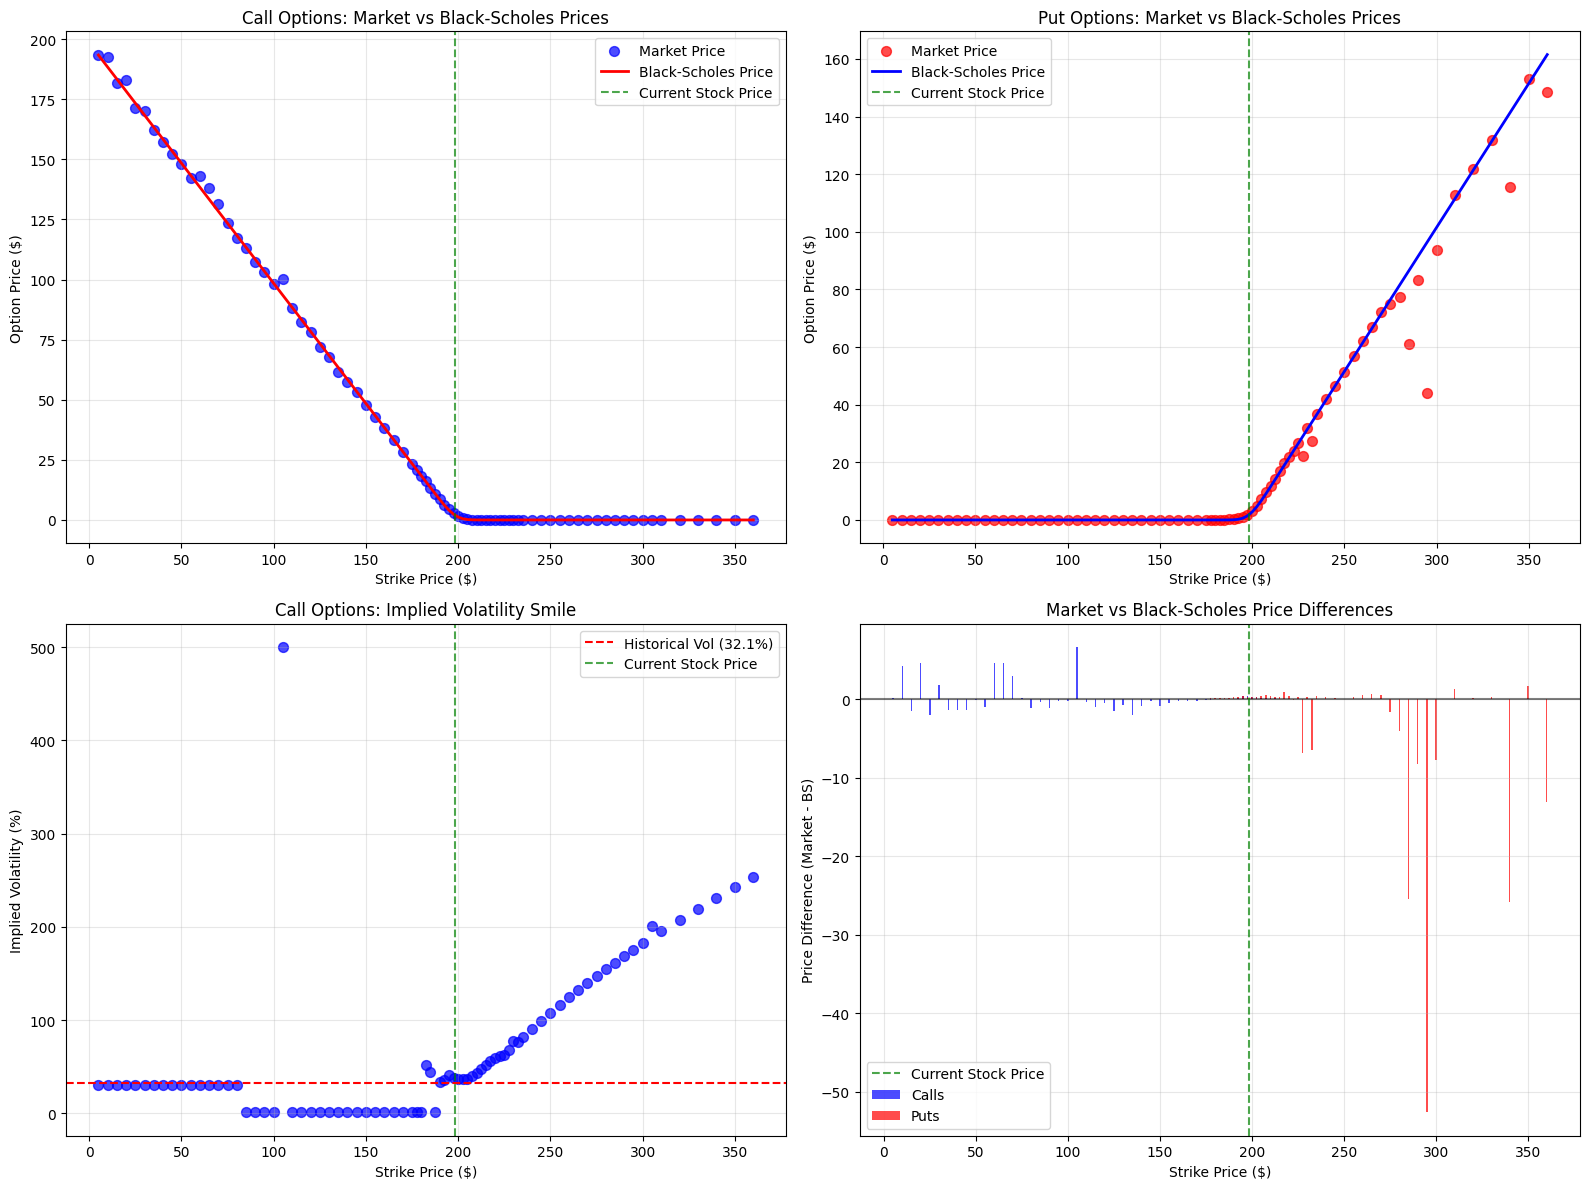

Black-Scholes Analysis for MSFT
Current Price: $479.14
Historical Volatility: 0.2539 (25.39%)
Current 10Y Treasury Rate: 0.0445 (4.45%)
Fetched option data for 2025-06-20
Time to expiration: 2 days
Call options: 138, Put options: 122


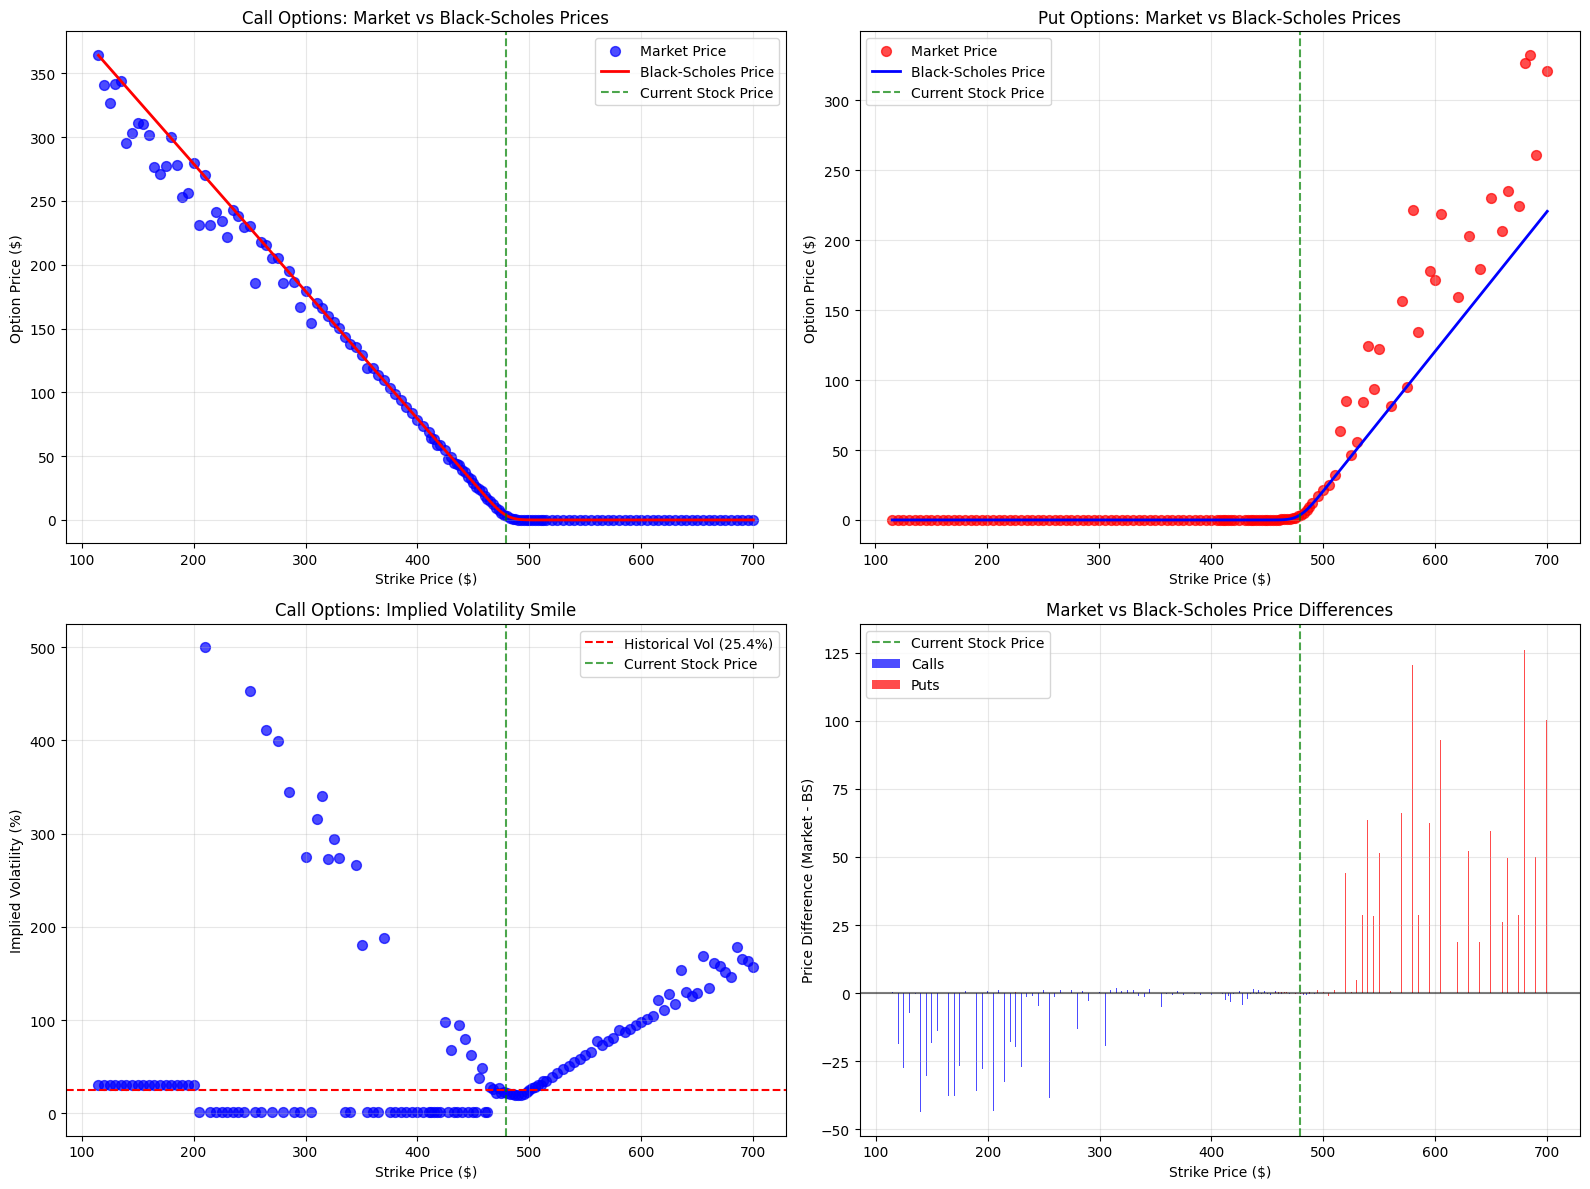

Black-Scholes Analysis for TSLA
Current Price: $329.13
Historical Volatility: 0.7341 (73.41%)
Current 10Y Treasury Rate: 0.0445 (4.45%)
Fetched option data for 2025-06-20
Time to expiration: 2 days
Call options: 185, Put options: 186


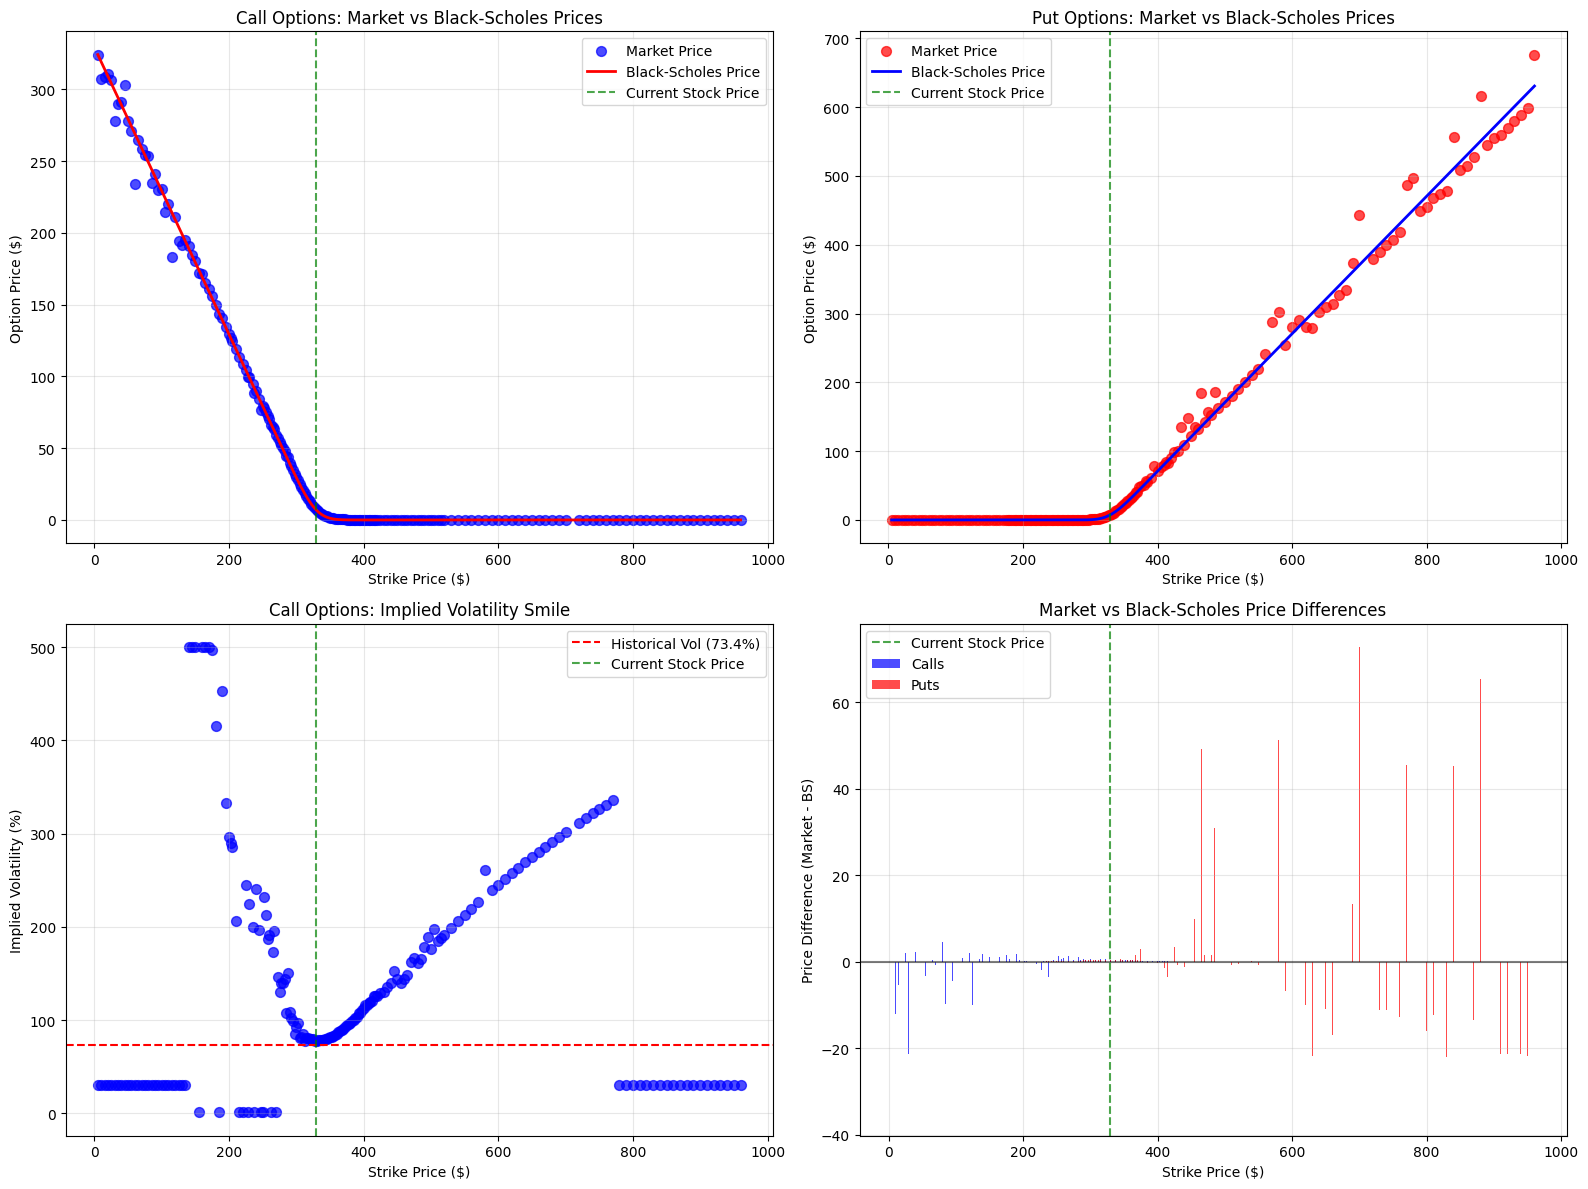

Black-Scholes Analysis for GOOG
Current Price: $177.94
Historical Volatility: 0.3156 (31.56%)
Current 10Y Treasury Rate: 0.0445 (4.45%)
Fetched option data for 2025-06-20
Time to expiration: 2 days
Call options: 58, Put options: 55


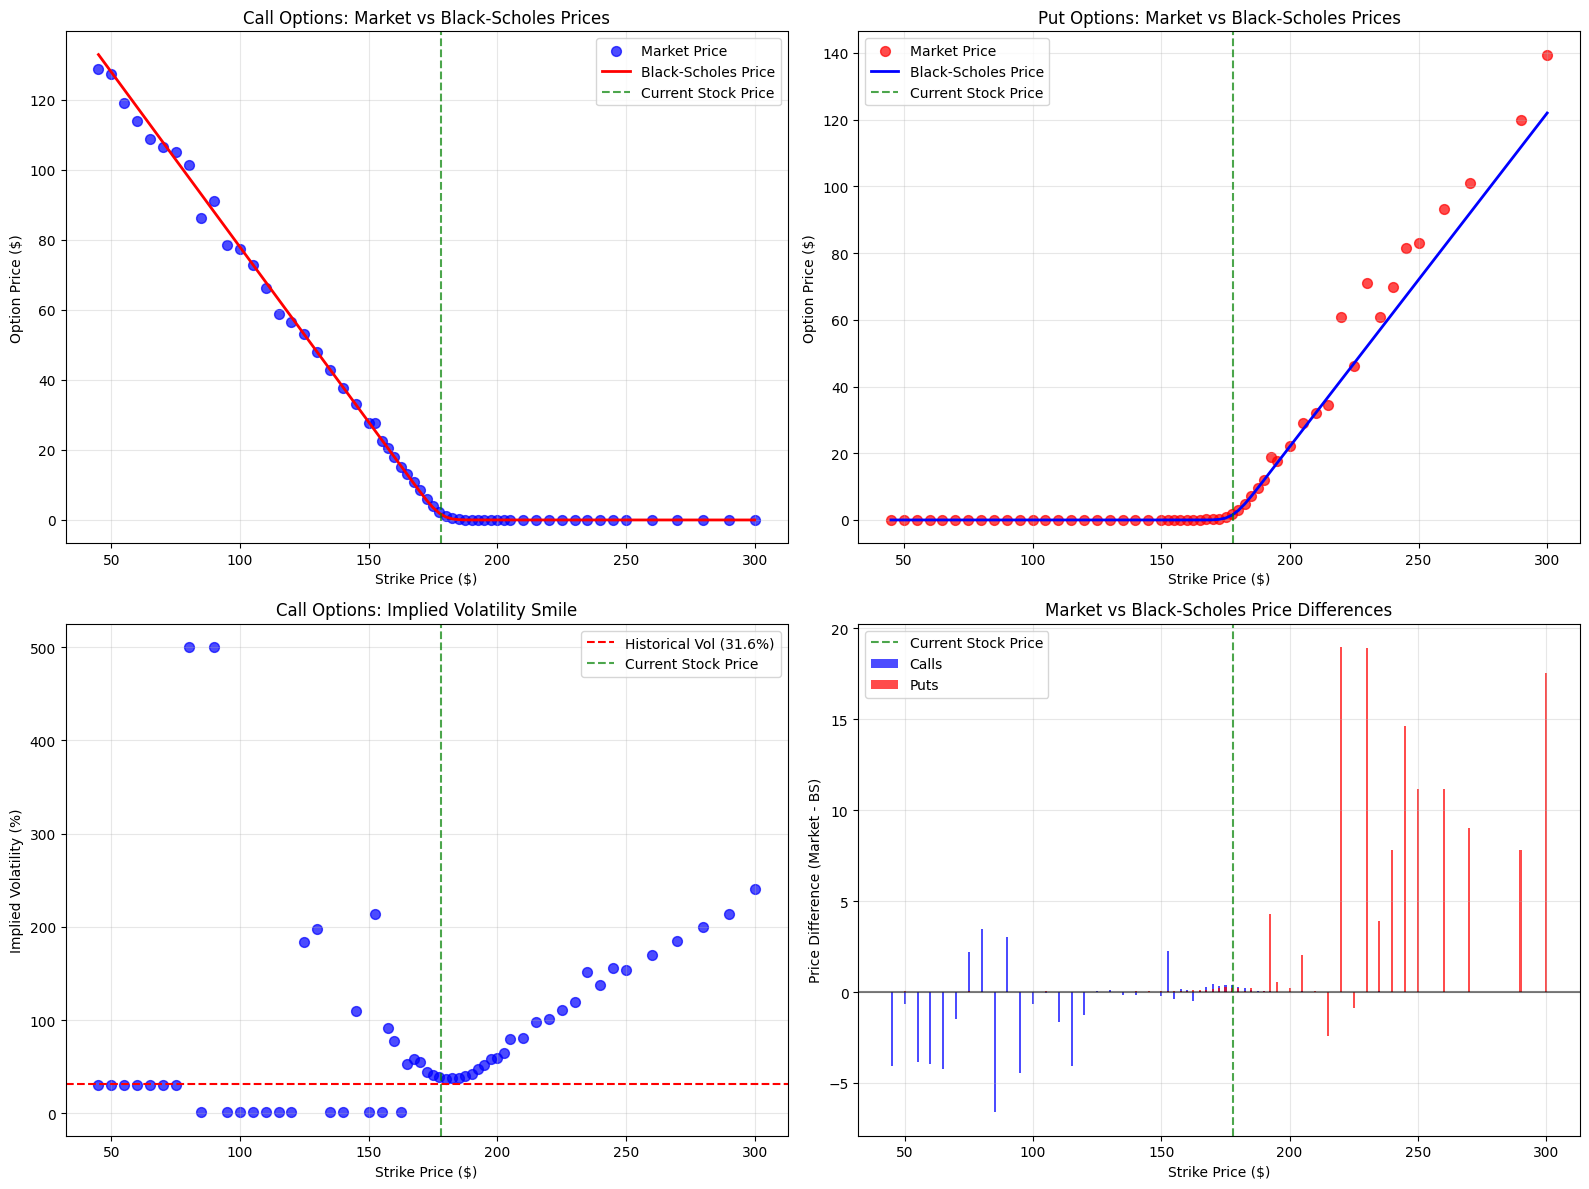

Black-Scholes Analysis for NVDA
Current Price: $144.69
Historical Volatility: 0.5875 (58.75%)
Current 10Y Treasury Rate: 0.0445 (4.45%)
Fetched option data for 2025-06-20
Time to expiration: 2 days
Call options: 524, Put options: 497


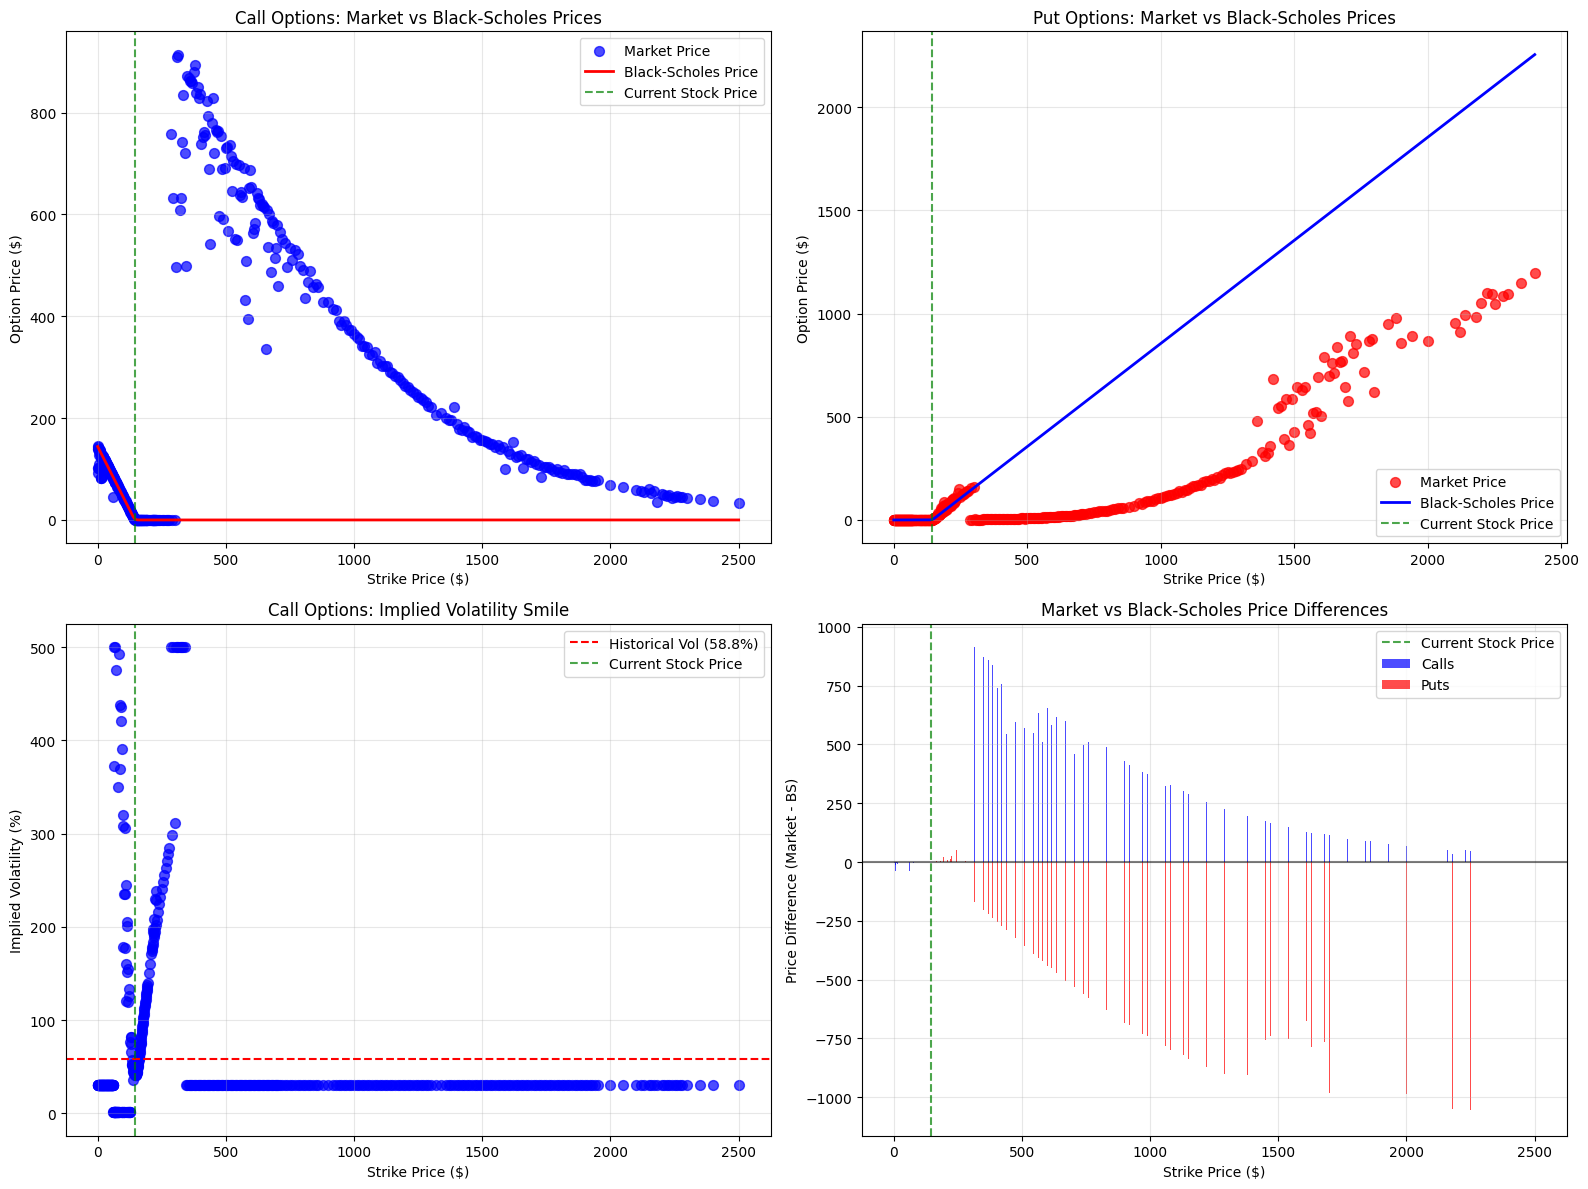

Black-Scholes Analysis for META
Current Price: $702.12
Historical Volatility: 0.3704 (37.04%)
Current 10Y Treasury Rate: 0.0445 (4.45%)
Fetched option data for 2025-06-20
Time to expiration: 2 days
Call options: 248, Put options: 225


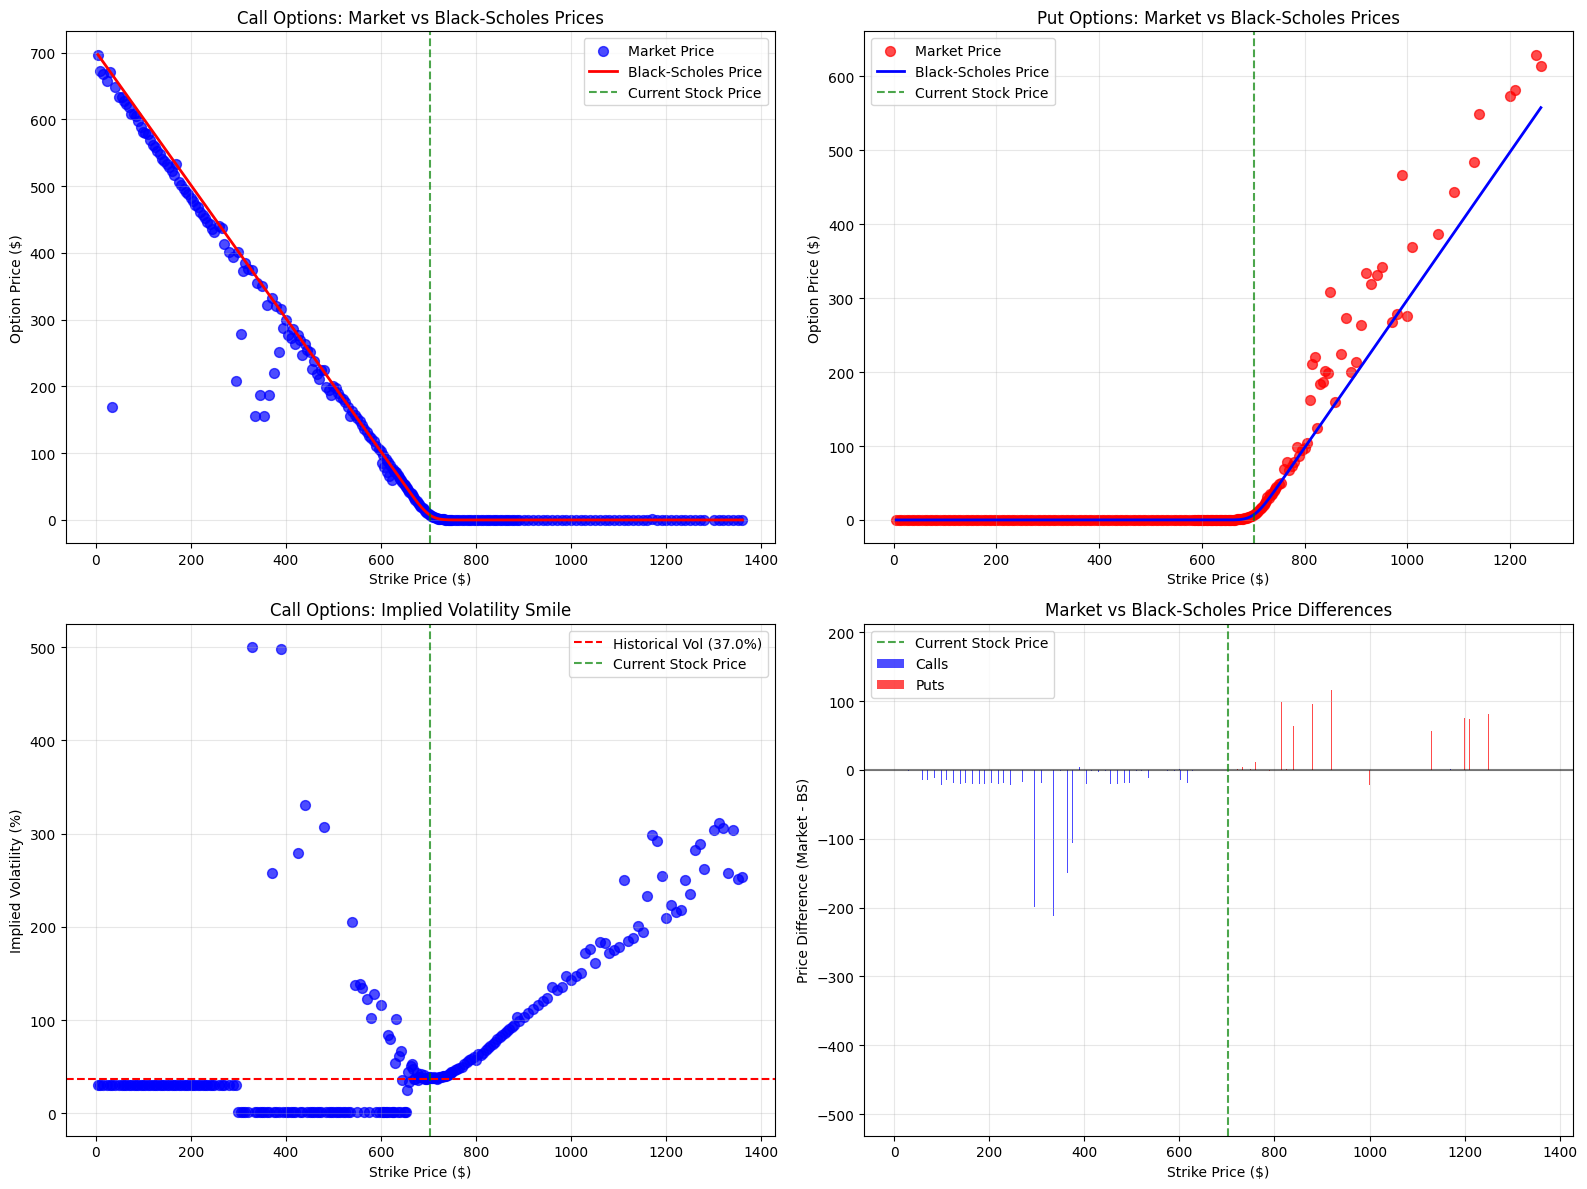

Black-Scholes Analysis for SNPS
Current Price: $479.41
Historical Volatility: 0.4187 (41.87%)
Current 10Y Treasury Rate: 0.0445 (4.45%)
Fetched option data for 2025-06-20
Time to expiration: 2 days
Call options: 56, Put options: 54


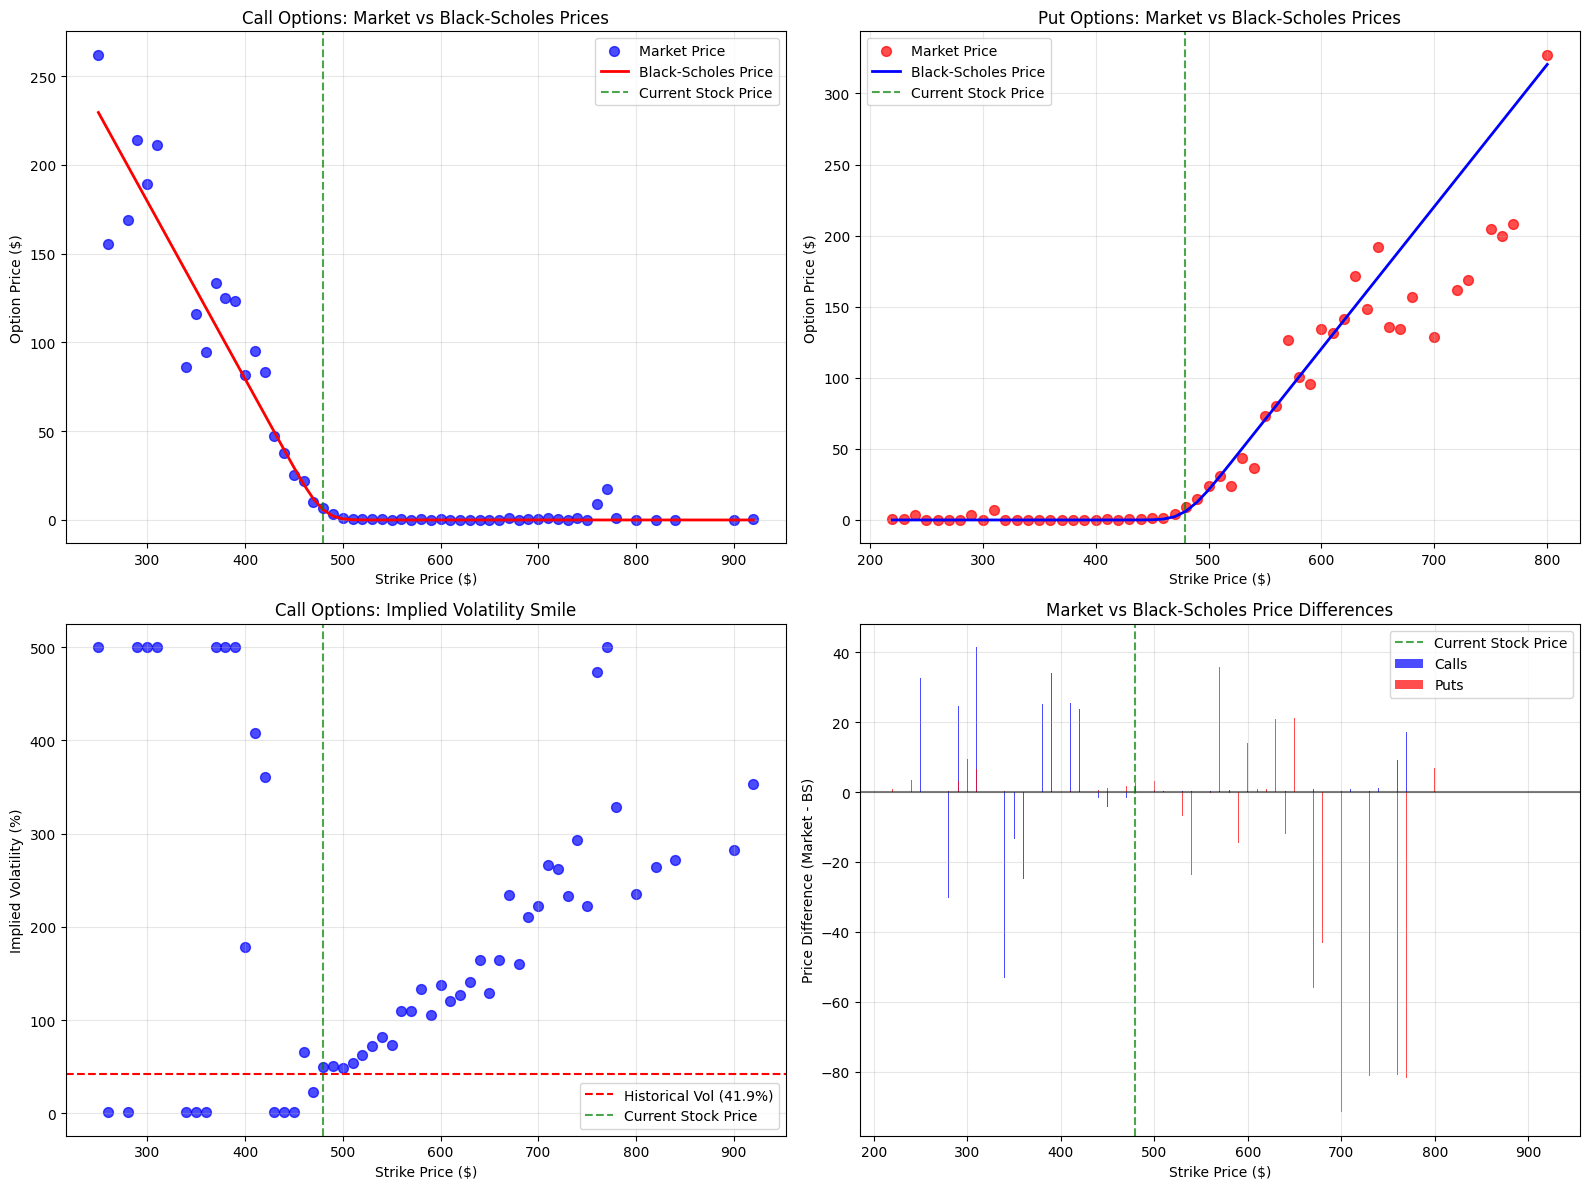

Black-Scholes Analysis for CDNS
Current Price: $300.81
Historical Volatility: 0.4281 (42.81%)
Current 10Y Treasury Rate: 0.0445 (4.45%)
Fetched option data for 2025-06-20
Time to expiration: 2 days
Call options: 59, Put options: 50


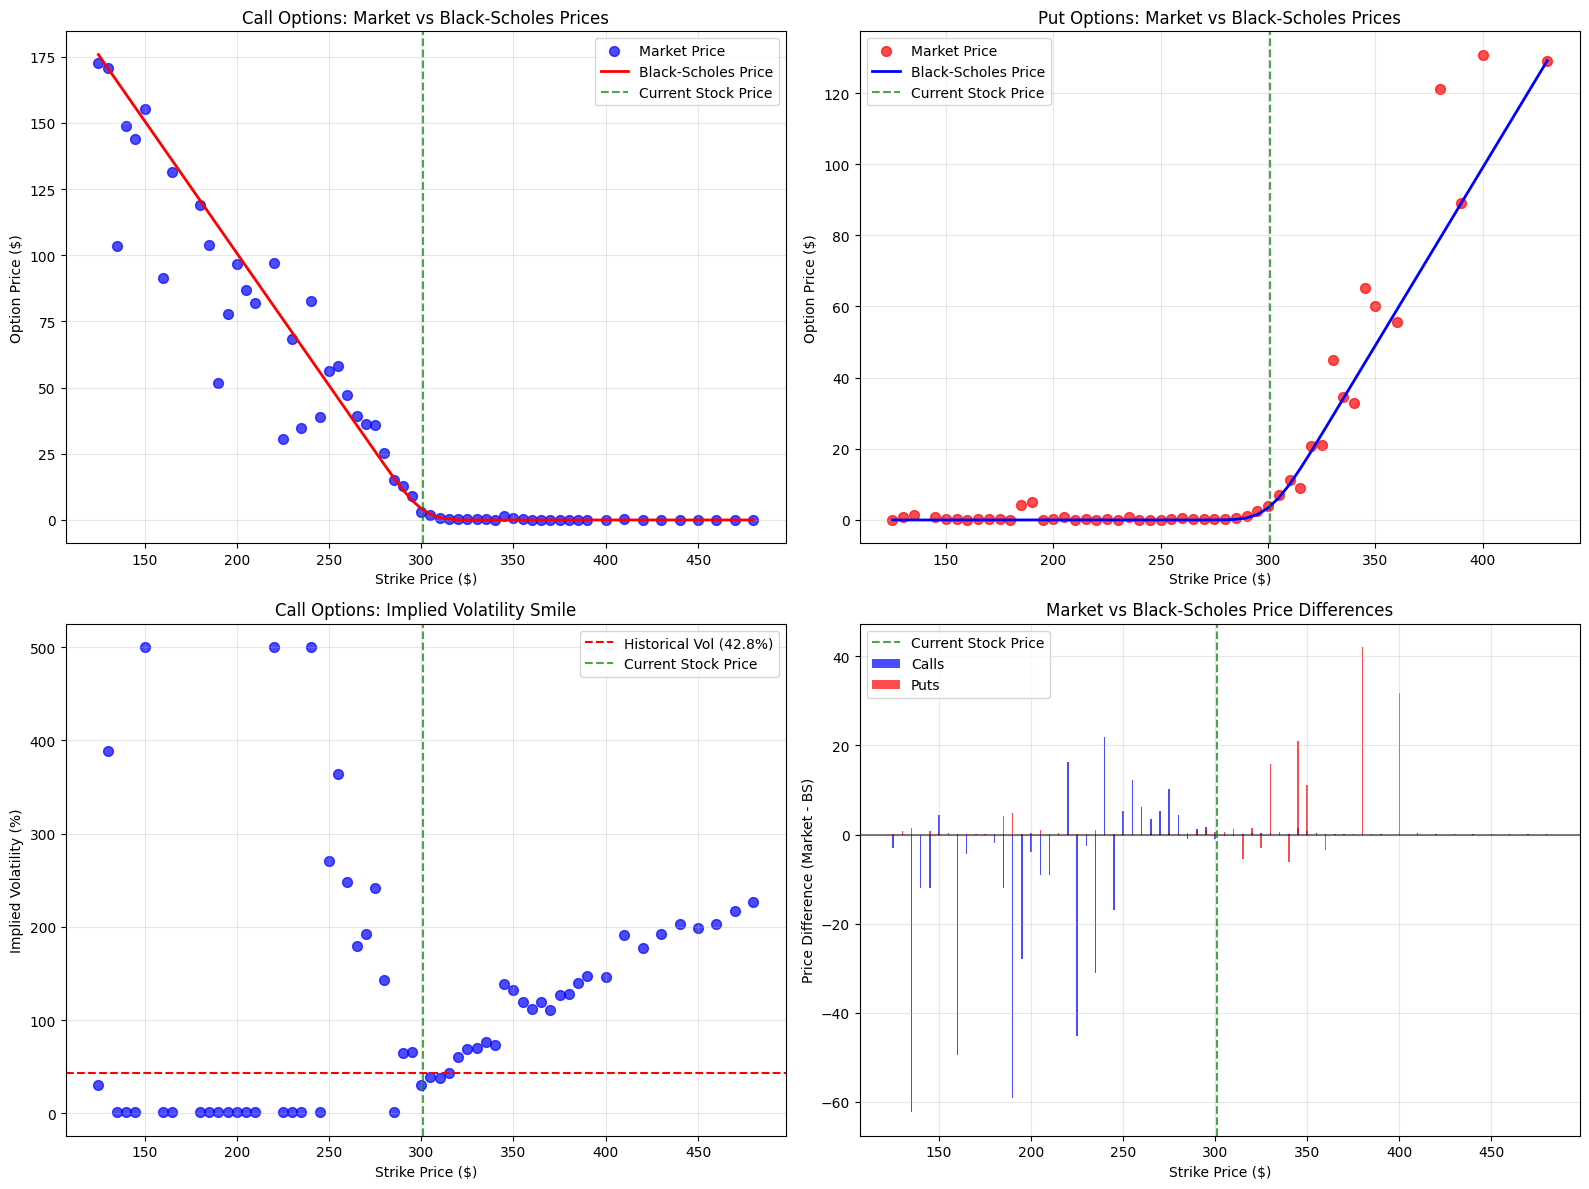

Black-Scholes Analysis for XOM
Current Price: $112.48
Historical Volatility: 0.2409 (24.09%)
Current 10Y Treasury Rate: 0.0445 (4.45%)
Fetched option data for 2025-06-20
Time to expiration: 2 days
Call options: 61, Put options: 56


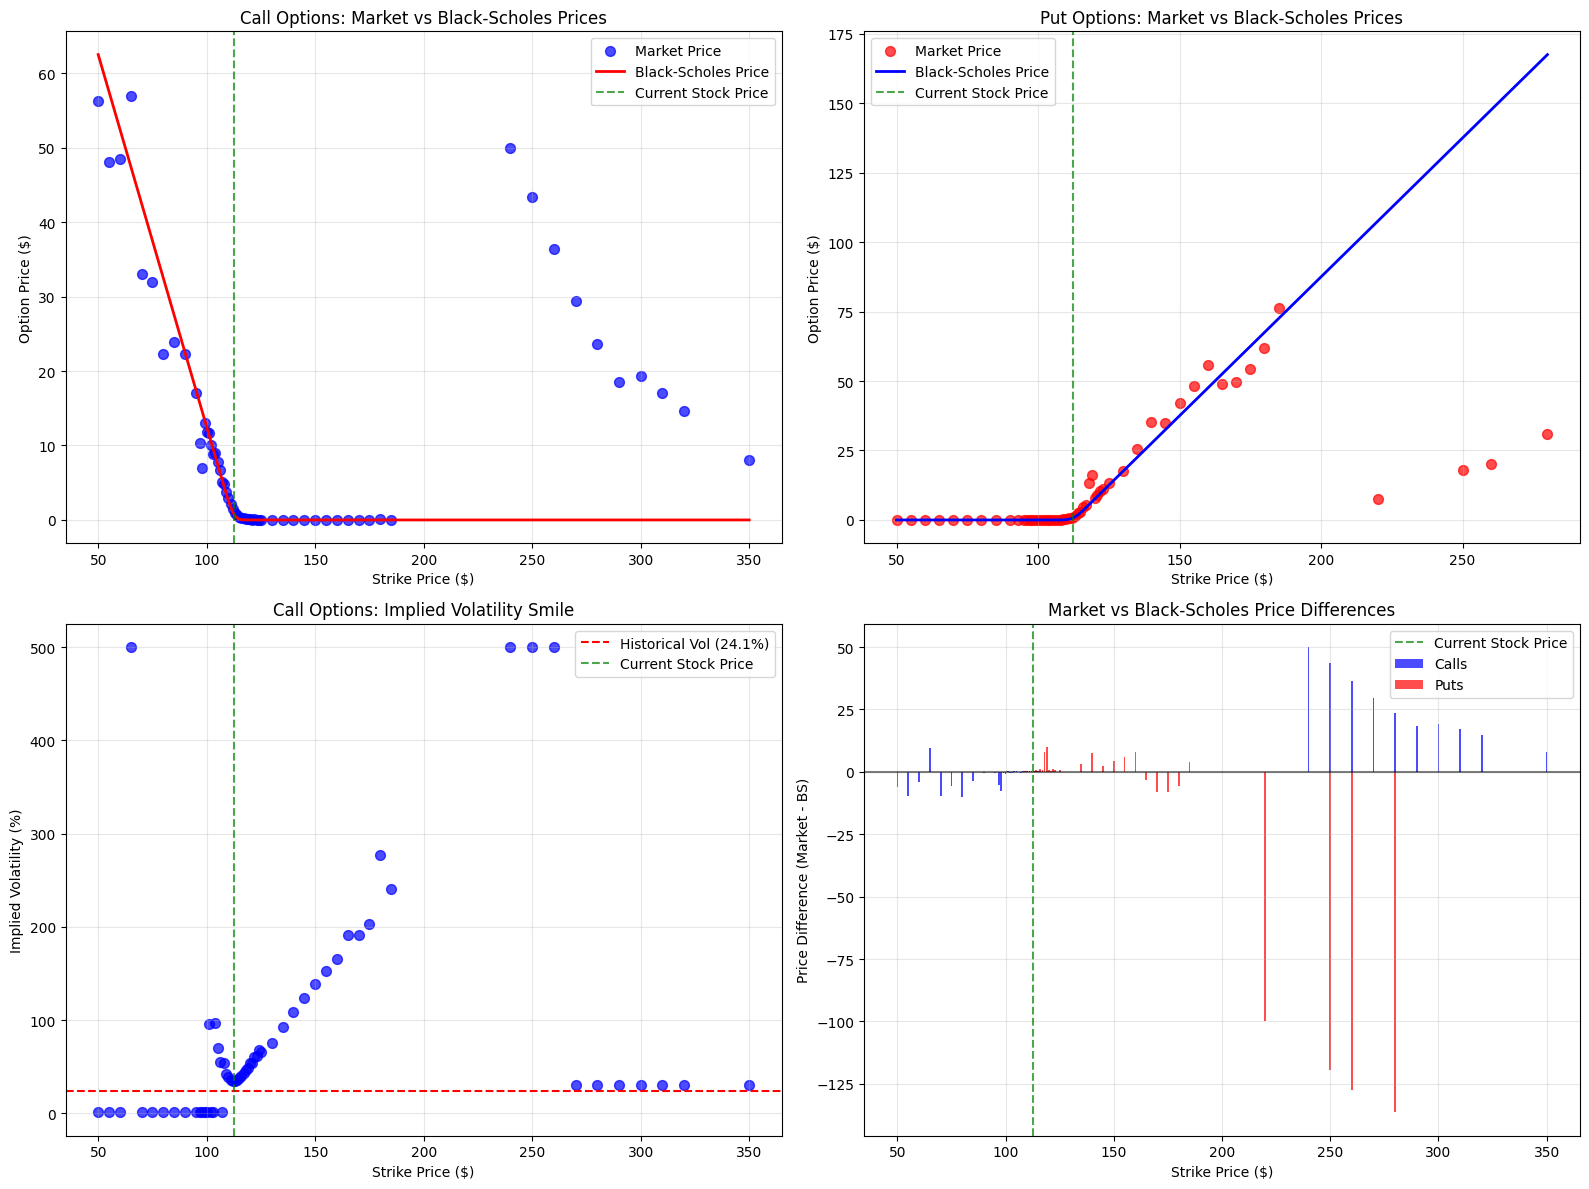

Black-Scholes Analysis for JPM
Current Price: $270.36
Historical Volatility: 0.2816 (28.16%)
Current 10Y Treasury Rate: 0.0445 (4.45%)
Fetched option data for 2025-06-20
Time to expiration: 2 days
Call options: 67, Put options: 63


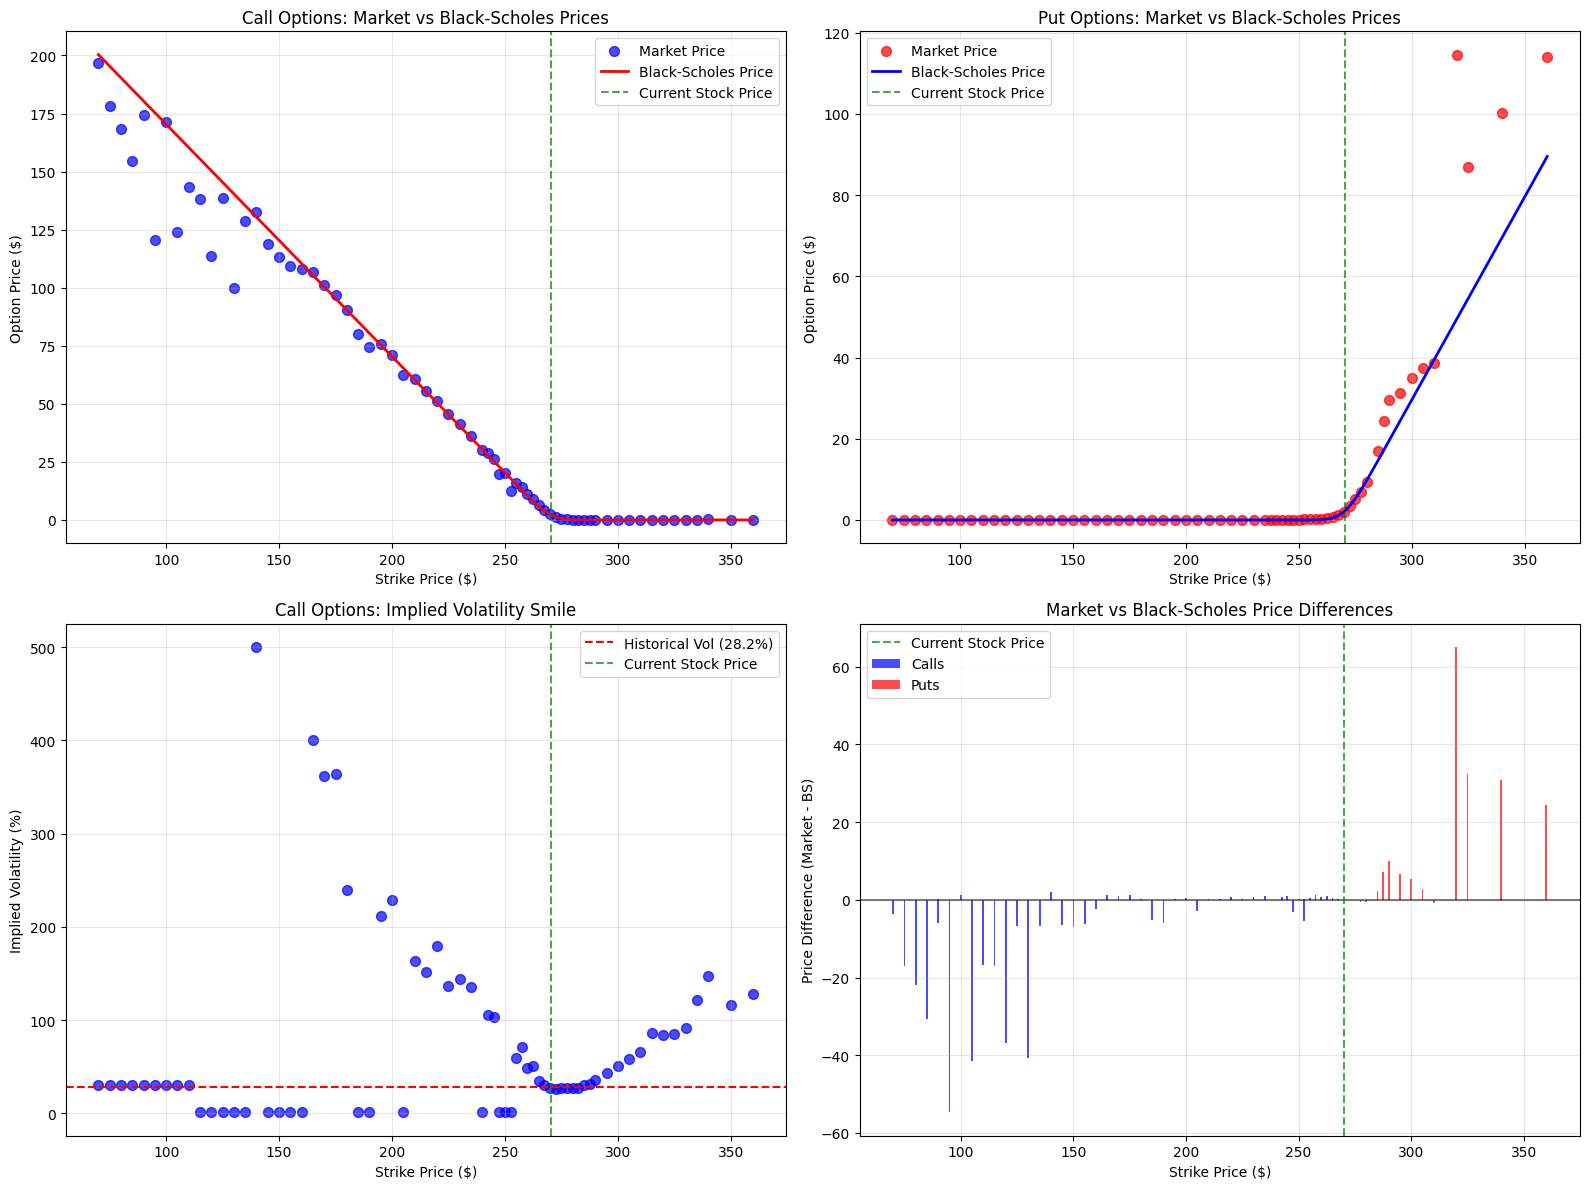

Black-Scholes Analysis for WMT
Current Price: $94.29
Historical Volatility: 0.2401 (24.01%)
Current 10Y Treasury Rate: 0.0445 (4.45%)
Fetched option data for 2025-06-20
Time to expiration: 2 days
Call options: 83, Put options: 82


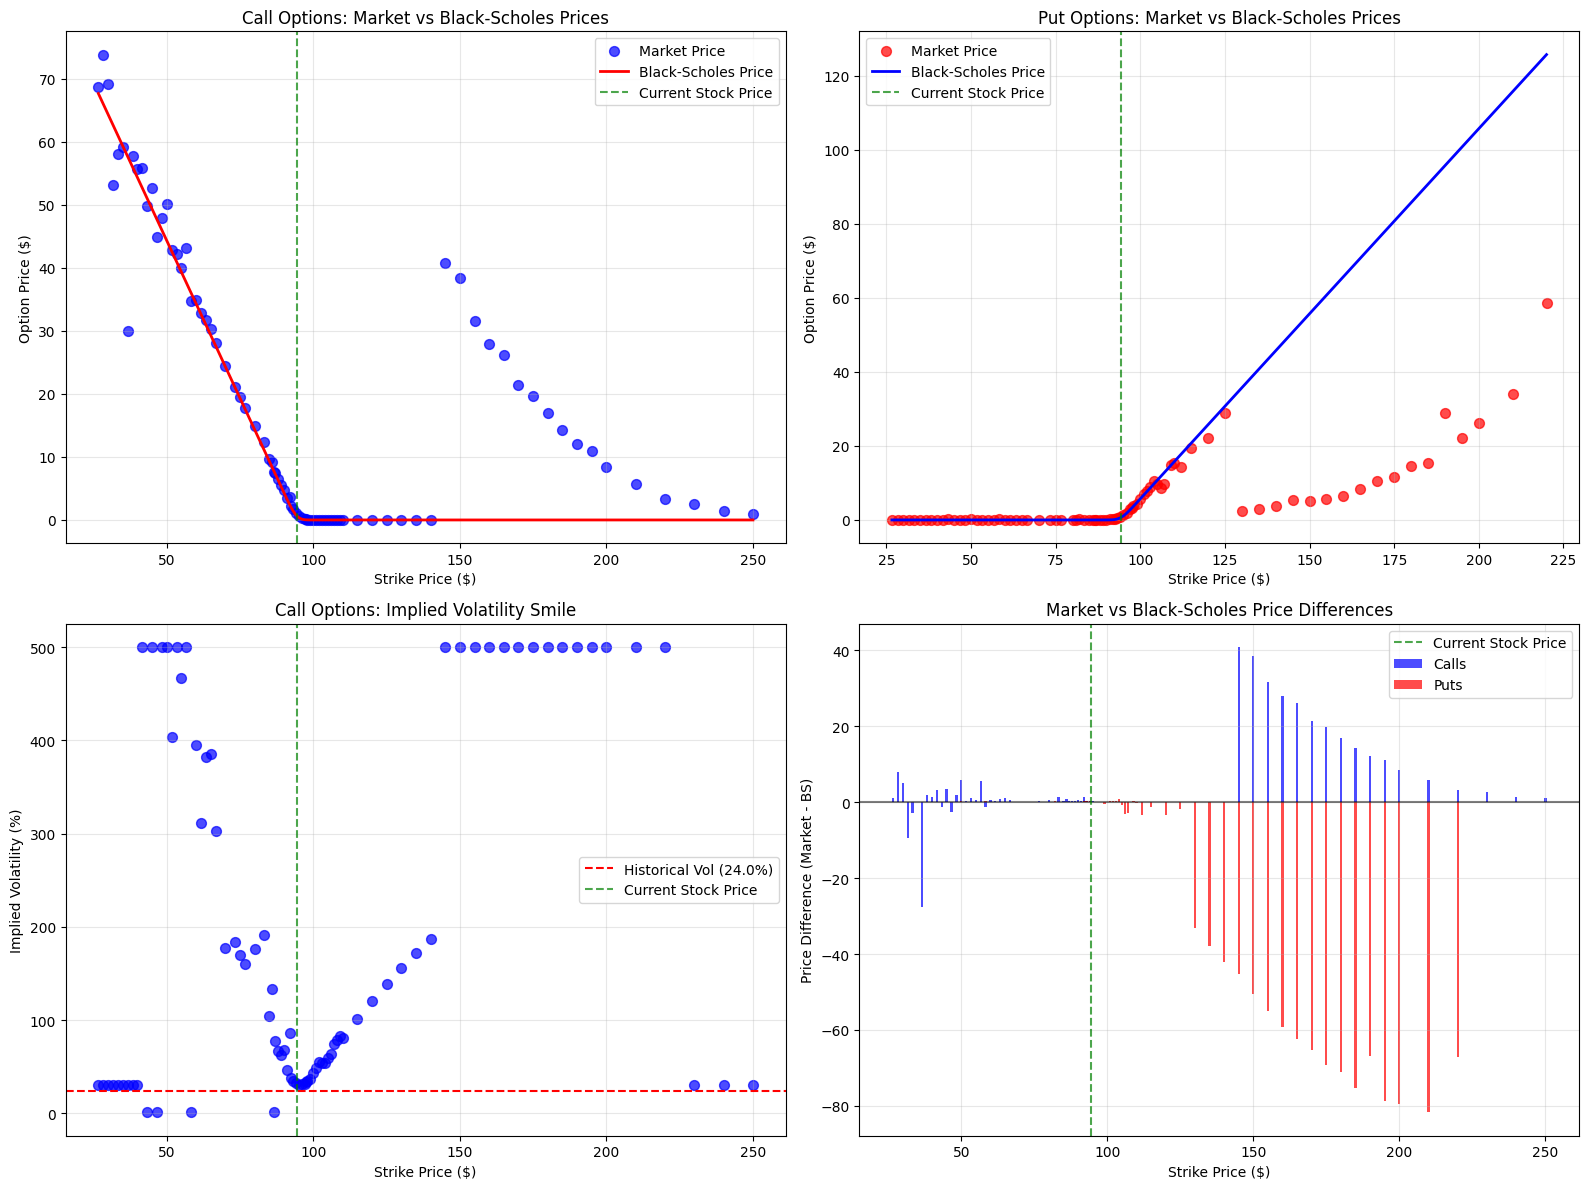

Black-Scholes Analysis for AMC
Current Price: $3.13
Historical Volatility: 0.5380 (53.80%)
Current 10Y Treasury Rate: 0.0445 (4.45%)
Fetched option data for 2025-06-20
Time to expiration: 2 days
Call options: 23, Put options: 22


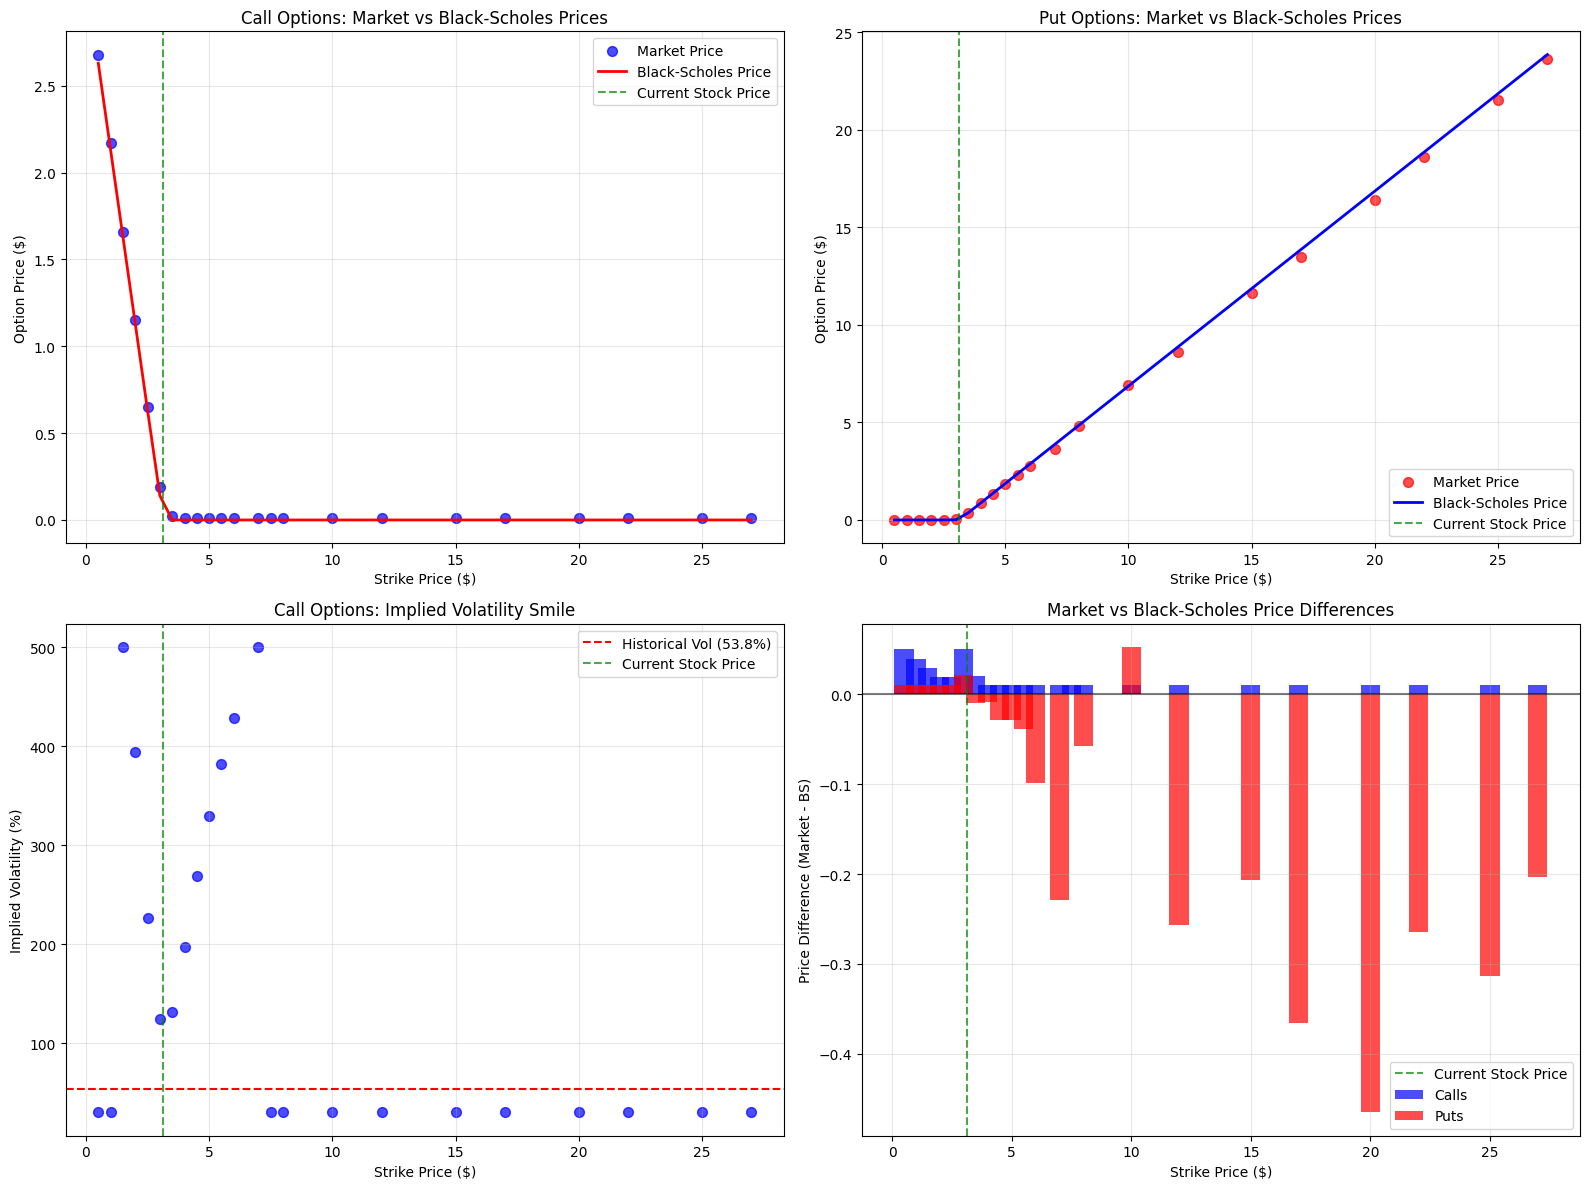

In [ ]:
for ticker in stocklist:
    comparison_data = run_enhanced_analysis(ticker, 0)

<div style="background-color: #f3ca20; color: #000000; font-size: 18px; padding: 5px;">12. Conclusion


Investing of 50 000 USD based on Monte Carlo simulation will be positive and expected to return aproximately 15.7% for a period of 200 days. 

Monte Carlo Portfolio Mean - 65 014

VaR - 6 001 CVaR - 9 437

Z-Score of the simulation is 1.1 which is below treshhold of +/- 2 and can describing sumulation as normal risky.

Most of stocks have negative skew distribution of volumes and symetric destribution of returns.

Stocks could be divided into three groups - technical, conservative and meme. 

In NVDA we can see as outlier in the tail of PDF volumes of more than 1 bilion USD, which ia approcimattely 25% of average S&P 500 volume.

Strong (above 0.8) linear relationship in returns betwenn SNPS and CDNS, un expected low correlation of returns from GOOG and META as a companies with similar business.

Stocks with P-value below 0.05 are JPM, NVDA, WMT - for them we can reject H0 that significant evidence that the mean return is > 0

Some options show volatility smile - MSFT, TSLA, GOOG, META